In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [2]:
from utility import *
from trends import *
from plot import *
from kpi_computation import *
from forecast import *

1. The features in the dataset are continuous. They are as follows:
    - Power consumed by different components
    - Factors influencing power consumption 
    - Time series in an interval of 5 minutes for 2 vessels, spanning across a year. That makes it $12*24*365 = 105120$ data points for each vessel.


In [3]:
# Read the data
df = pd.read_csv('data/data.csv', header = 0)
df.head()

,Start Time,End Time,Vessel Name,Power Galley 1 (MW),Power Galley 2 (MW),Power Service (MW),HVAC Chiller 1 Power (MW),HVAC Chiller 2 Power (MW),HVAC Chiller 3 Power (MW),Scrubber Power (MW),Sea Temperature (Celsius),Boiler 1 Fuel Flow Rate (L/h),Boiler 2 Fuel Flow Rate (L/h),Incinerator 1 Fuel Flow Rate (L/h),Diesel Generator 1 Power (MW),Diesel Generator 2 Power (MW),Diesel Generator 3 Power (MW),Diesel Generator 4 Power (MW),Latitude (Degrees),Longitude (Degrees),Relative Wind Angle (Degrees),True Wind Angle (Degrees),Depth (m),Relative Wind Direction (Degrees),True Wind Direction (Degrees),Draft (m),Speed Over Ground (knots),True Wind Speed (knots),Relative Wind Speed (knots),Speed Through Water (knots),Local Time (h),Trim (m),Propulsion Power (MW),Port Side Propulsion Power (MW),Starboard Side Propulsion Power (MW),Bow Thruster 1 Power (MW),Bow Thruster 2 Power (MW),Bow Thruster 3 Power (MW),Stern Thruster 1 Power (MW),Stern Thruster 2 Power (MW),Main Engine 1 Fuel Flow Rate (kg/h),Main Engine 2 Fuel Flow Rate (kg/h),Main Engine 3 Fuel Flow Rate (kg/h),Main Engine 4 Fuel Flow Rate (kg/h)
0,2023-01-01T00:00:00,2023-01-01T00:05:00,Vessel 1,0.0946,0.1384,5.4654,0.5074,0.0,0.4979,0.4191,27.3000,0.0000,0.0,19.0090,0.0,0.0,0.0,7.3349,17.72523,-65.45738,8.4428,10.9049,NaN,64.3112,66.7735,7.8721,7.6300,19.5050,27.0579,7.8881,19.67367,-0.1425,1.8691,0.8854,0.9837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1645.82000
1,2023-01-01T00:05:00,2023-01-01T00:10:00,Vessel 1,0.0540,0.1370,5.4387,0.5158,0.0,0.4982,0.4204,27.3000,47.7695,0.0,216.3180,0.0,0.0,0.0,7.3011,17.73088,-65.44803,41.3100,78.7817,NaN,62.8161,64.3452,7.8713,7.5800,19.2968,26.8067,7.7438,19.75763,-0.1405,1.8622,0.8737,0.9885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1643.78999
2,2023-01-01T00:10:00,2023-01-01T00:15:00,Vessel 1,0.0439,0.1785,5.5265,0.5117,0.0,0.5032,0.4199,27.3000,77.2034,0.0,439.4300,0.0,0.0,0.0,7.3299,17.73655,-65.43887,23.9997,33.6216,NaN,80.7356,90.3574,7.8718,7.4379,19.4491,25.8380,7.6320,19.84158,-0.1450,1.8036,0.8441,0.9595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1642.07000
3,2023-01-01T00:15:00,2023-01-01T00:20:00,Vessel 1,0.0733,0.1725,5.5257,0.5177,0.0,0.5103,0.4188,27.3076,60.6369,0.0,218.2797,0.0,0.0,0.0,7.3712,17.74202,-65.42980,14.5540,20.0348,NaN,75.9723,81.4529,7.8710,7.3979,20.6231,27.6498,7.5080,19.92551,-0.1308,1.8457,0.8543,0.9914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1650.71000
4,2023-01-01T00:20:00,2023-01-01T00:25:00,Vessel 1,0.0780,0.1397,5.4634,0.5169,0.0,0.5100,0.4203,27.3518,55.2184,0.0,0.0000,0.0,0.0,0.0,7.3032,17.74713,-65.42042,14.5632,20.0328,NaN,74.6509,80.1204,7.8707,7.4343,20.4554,27.5341,7.5521,20.00947,-0.1269,1.8399,0.8467,0.9932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1644.54000


In [ ]:
df.describe()

In [ ]:
# Check the data types and column names
df.dtypes

**The features in the entire dataset are (without the Start time, End Time and the Vessel Name):**
| Column Name |
|-------------|
| Power Galley 1 (MW) |
| Power Galley 2 (MW) |
| Power Service (MW) |
| HVAC Chiller 1 Power (MW) |
| HVAC Chiller 2 Power (MW) |
| HVAC Chiller 3 Power (MW) |
| Scrubber Power (MW) |
| Sea Temperature (Celsius) |
| Boiler 1 Fuel Flow Rate (L/h) |
| Boiler 2 Fuel Flow Rate (L/h) |
| Incinerator 1 Fuel Flow Rate (L/h) |
| Diesel Generator 1 Power (MW) |
| Diesel Generator 2 Power (MW) |
| Diesel Generator 3 Power (MW) |
| Diesel Generator 4 Power (MW) |
| Latitude (Degrees) |
| Longitude (Degrees) |
| Relative Wind Angle (Degrees) |
| True Wind Angle (Degrees) |
| Depth (m) |
| Relative Wind Direction (Degrees) |
| True Wind Direction (Degrees) |
| Draft (m) |
| Speed Over Ground (knots) |
| True Wind Speed (knots) |
| Relative Wind Speed (knots) |
| Speed Through Water (knots) |
| Local Time (h) |
| Trim (m) |
| Propulsion Power (MW) |
| Port Side Propulsion Power (MW) |
| Starboard Side Propulsion Power (MW) |
| Bow Thruster 1 Power (MW) |
| Bow Thruster 2 Power (MW) |
| Bow Thruster 3 Power (MW) |
| Stern Thruster 1 Power (MW) |
| Stern Thruster 2 Power (MW) |
| Main Engine 1 Fuel Flow Rate (kg/h) |
| Main Engine 2 Fuel Flow Rate (kg/h) |
| Main Engine 3 Fuel Flow Rate (kg/h) |
| Main Engine 4 Fuel Flow Rate (kg/h) |

# Vessel - Level Analysis

In [5]:
# dfv = pick_vessel(df, 'Vessel 1')
dfv = pick_vessel(df, 'Vessel 2')
# dfv = df

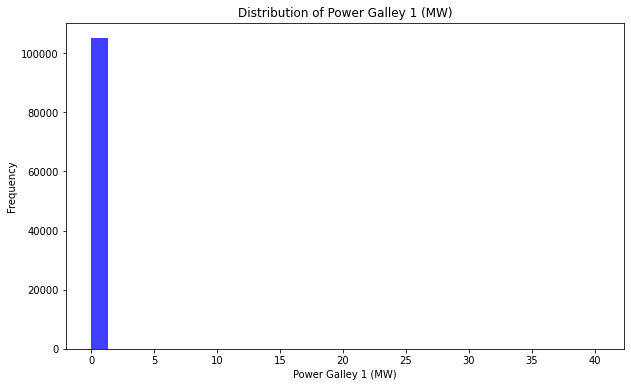

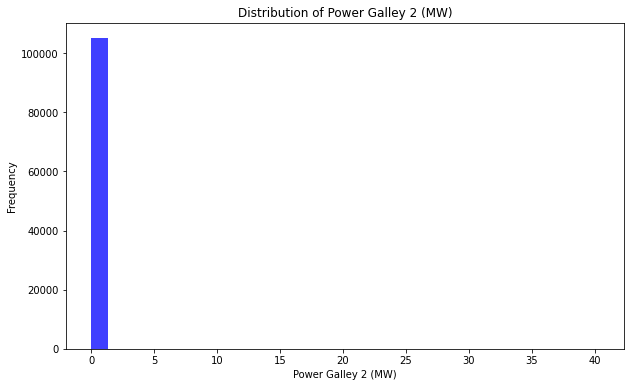

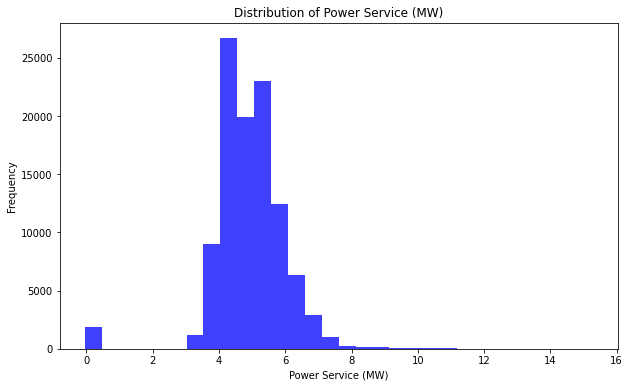

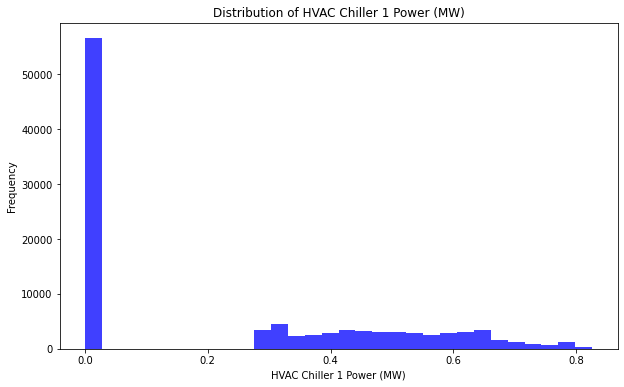

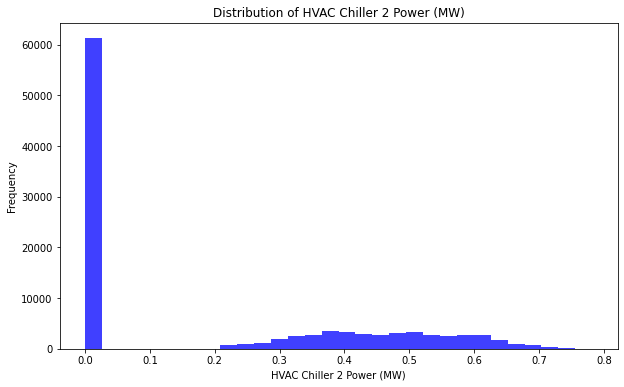

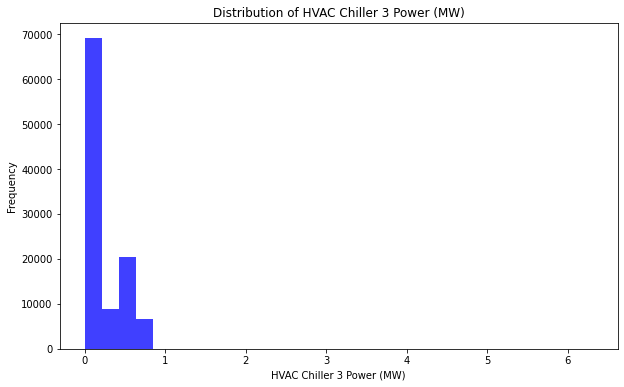

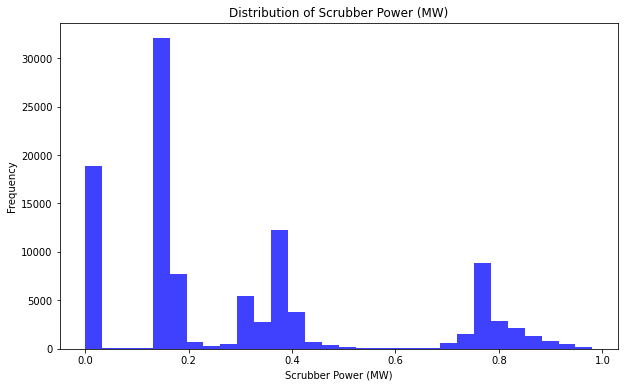

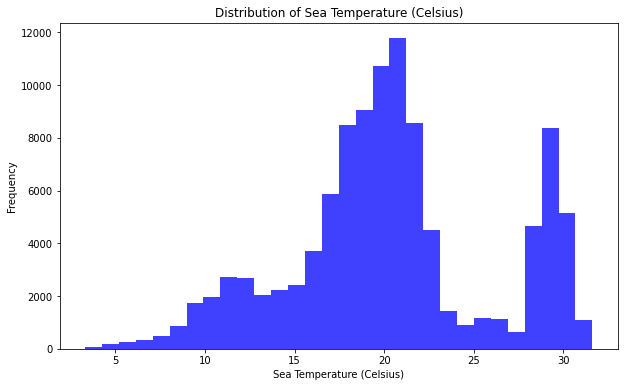

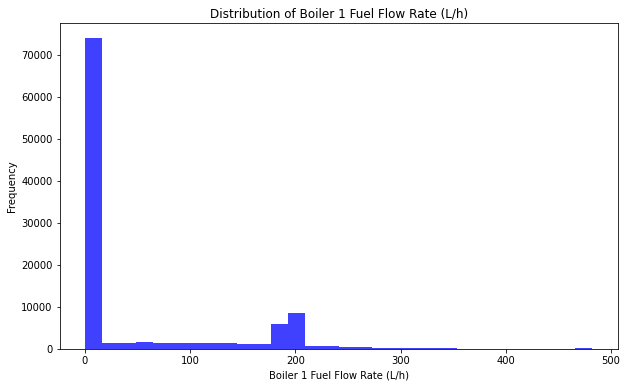

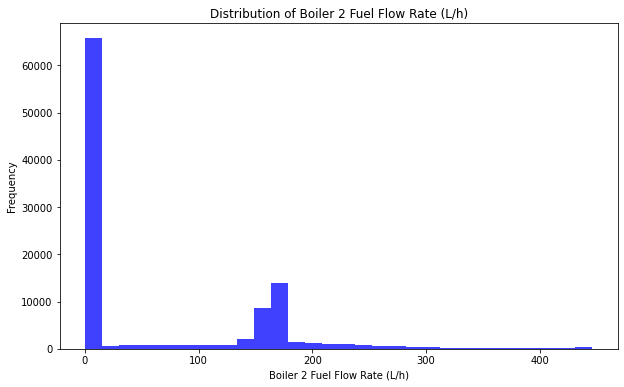

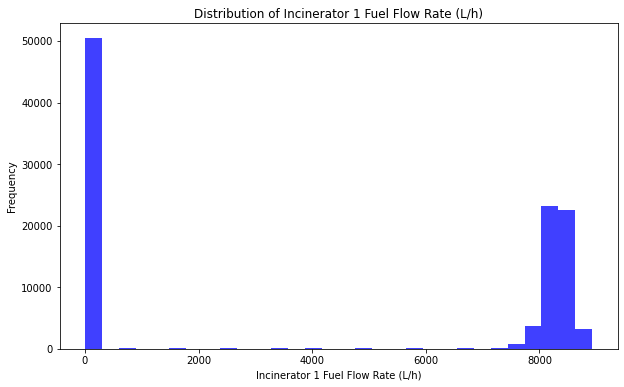

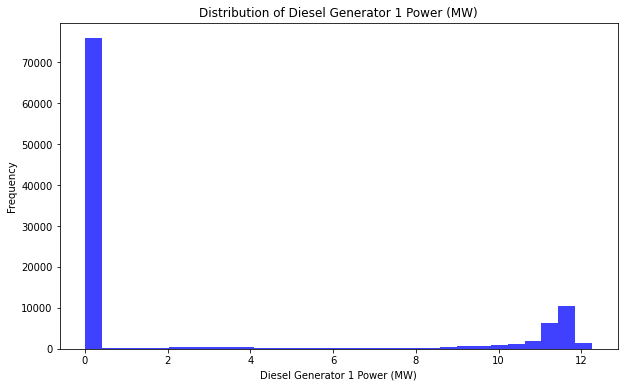

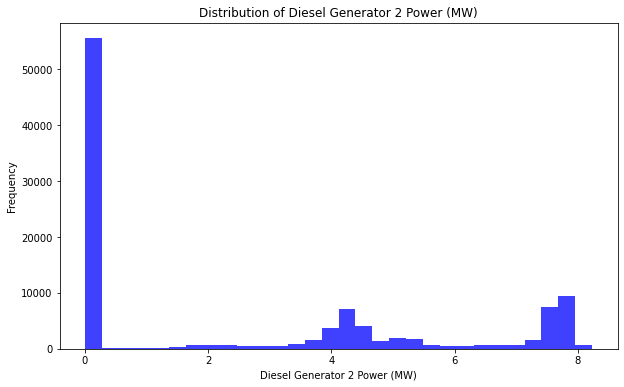

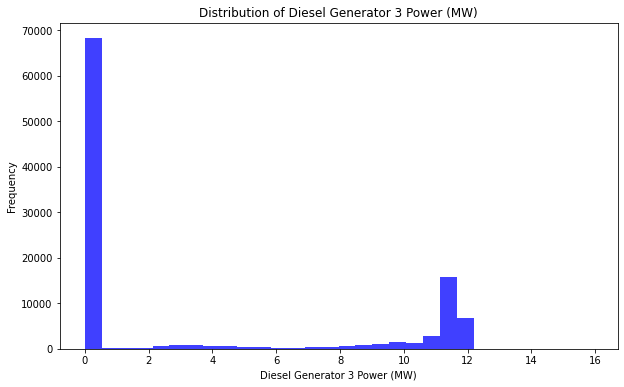

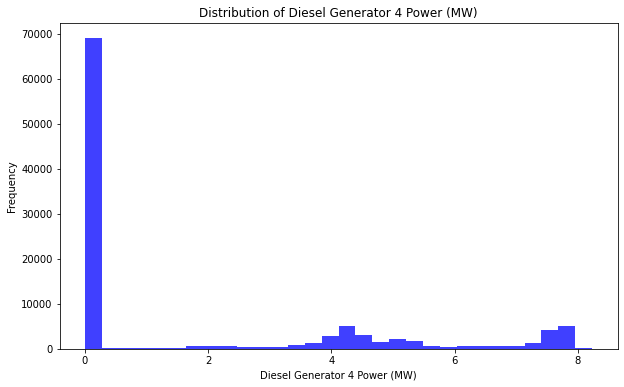

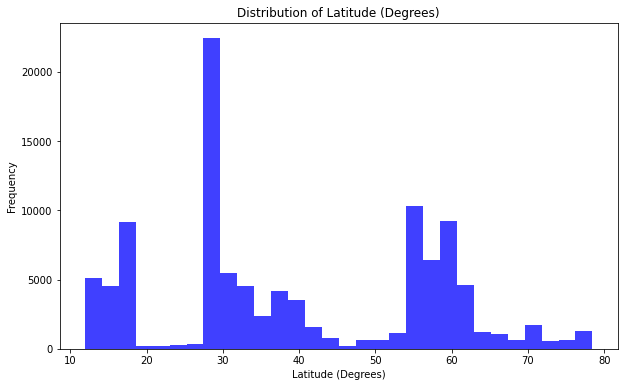

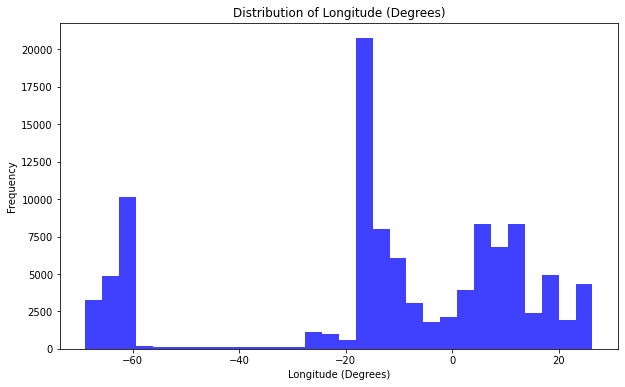

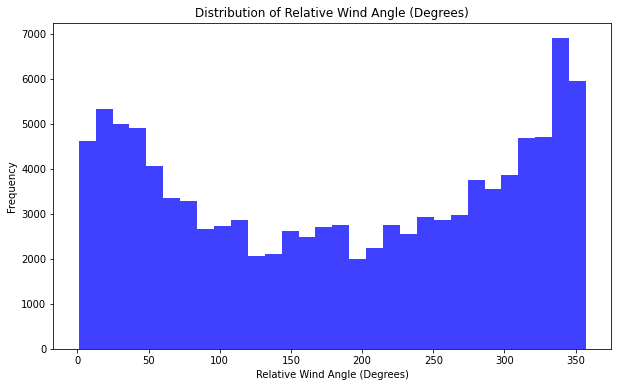

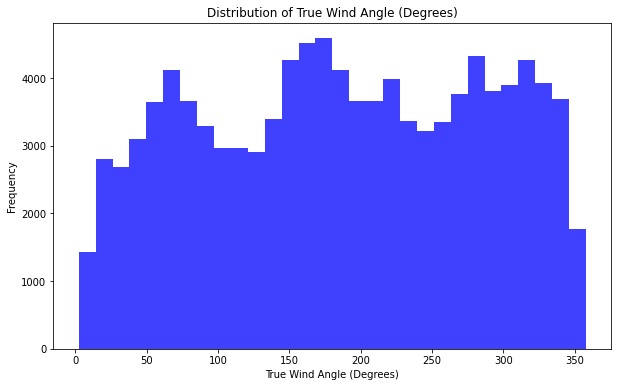

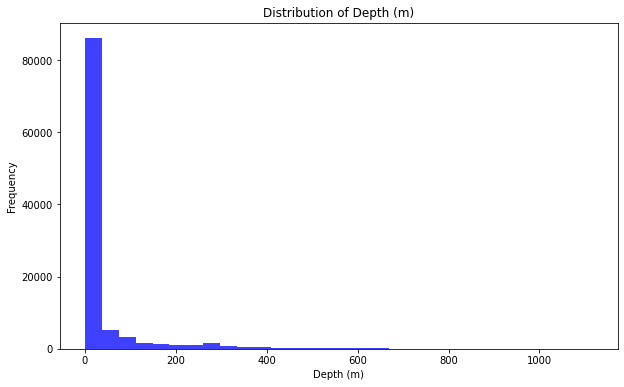

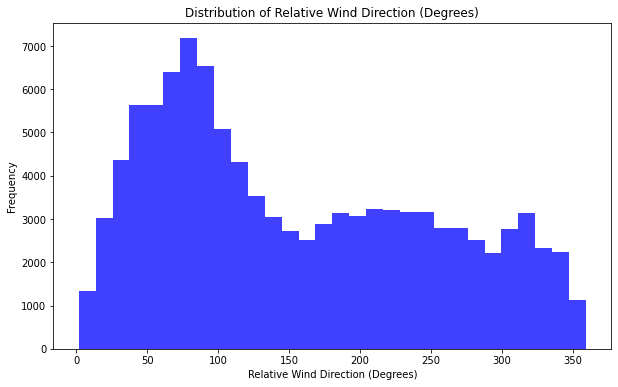

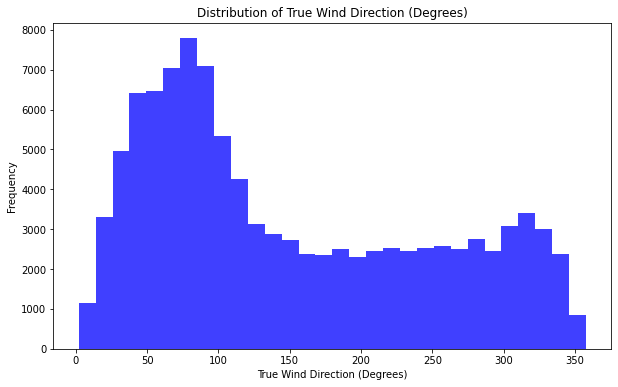

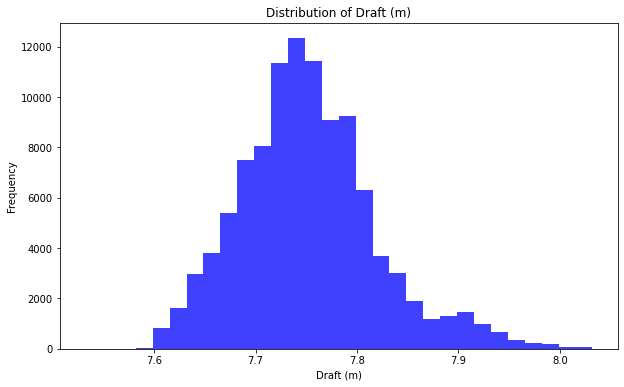

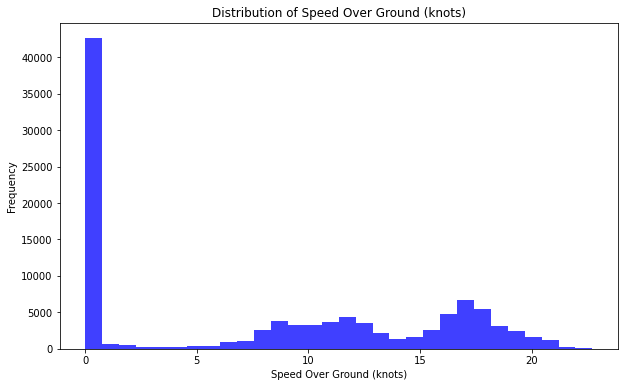

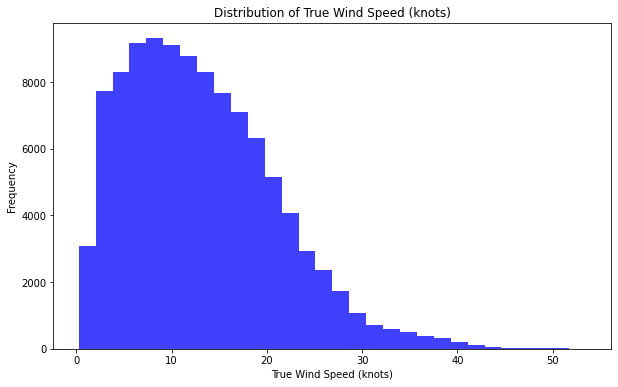

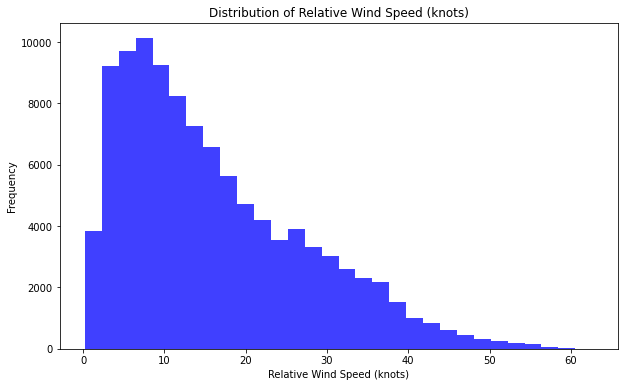

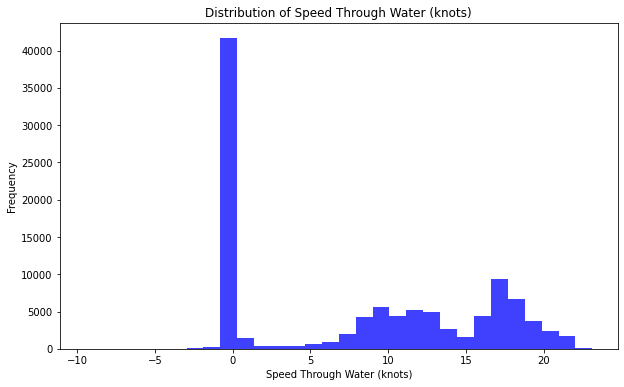

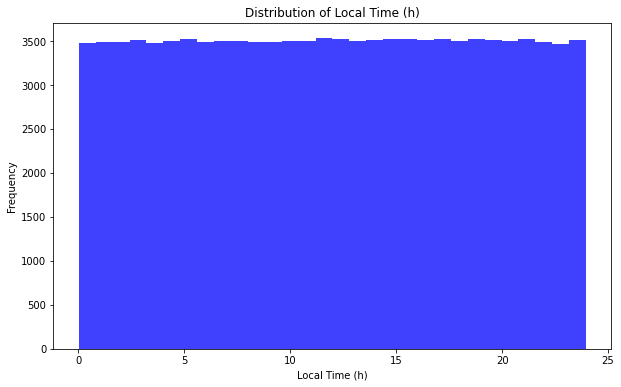

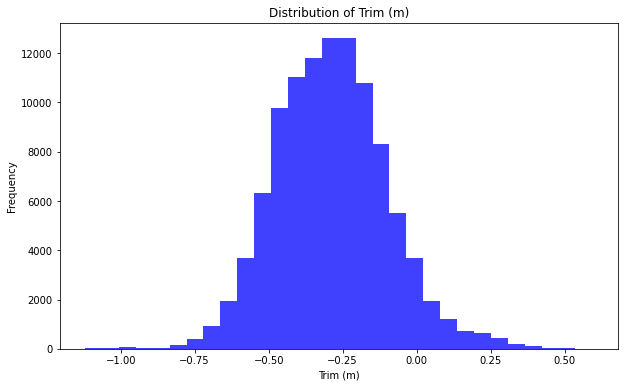

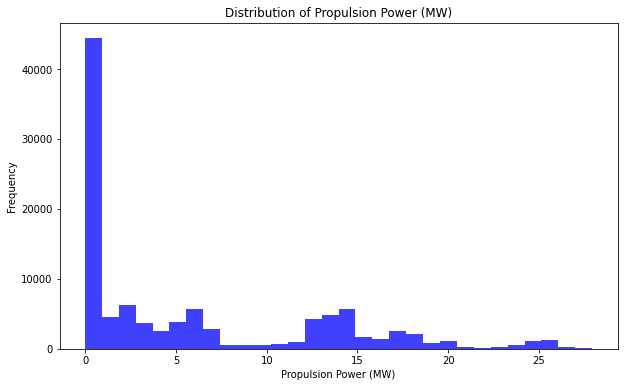

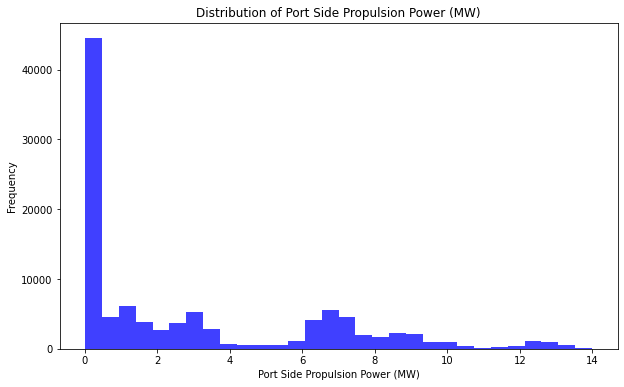

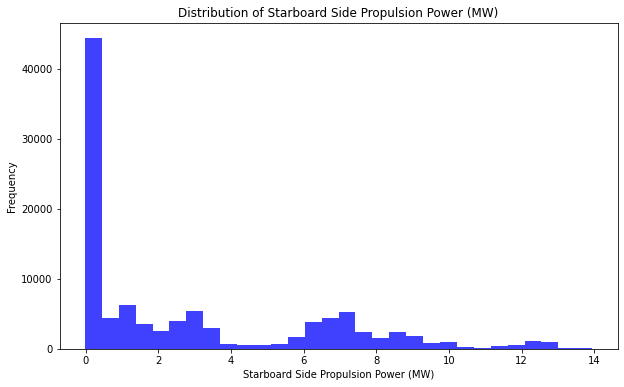

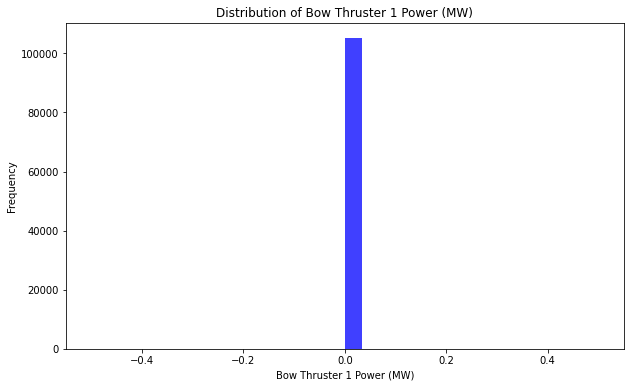

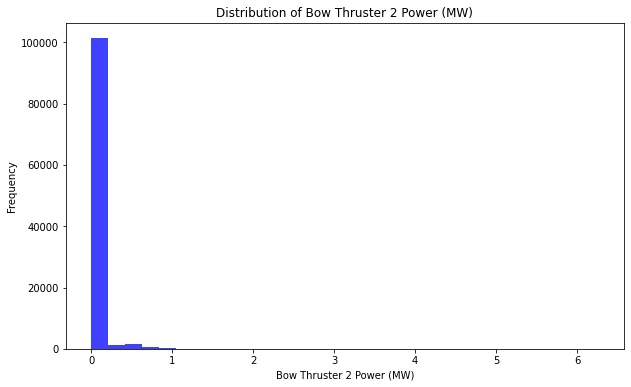

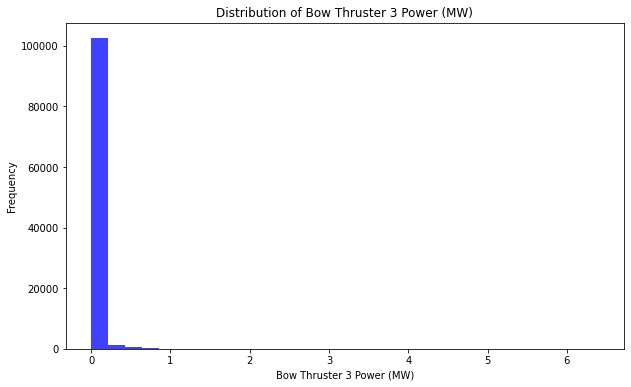

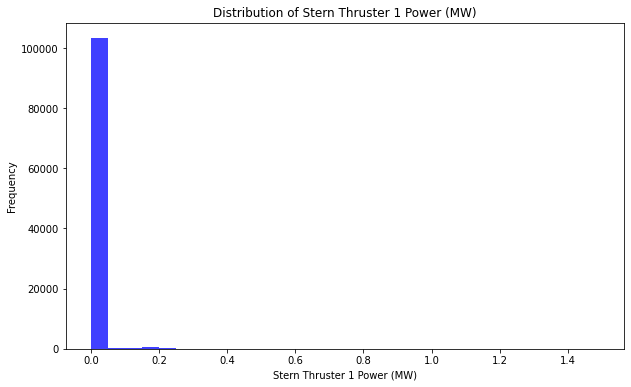

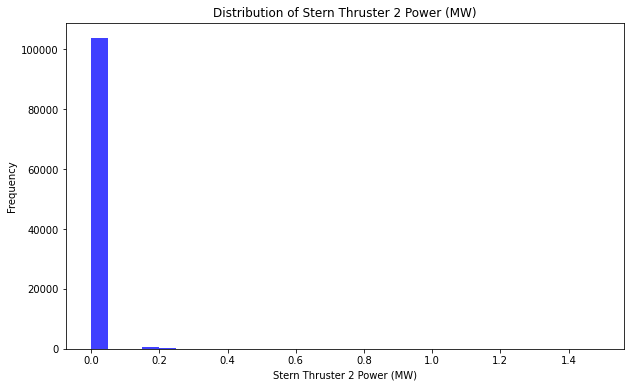

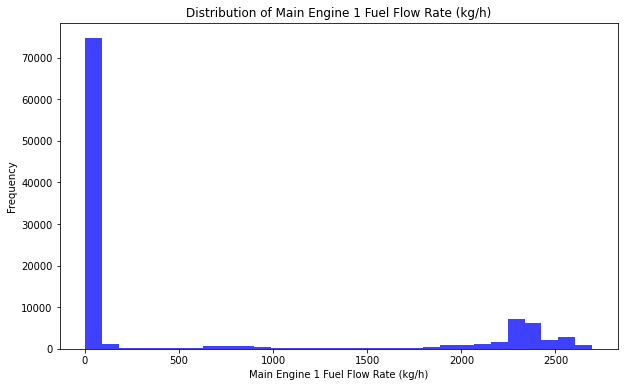

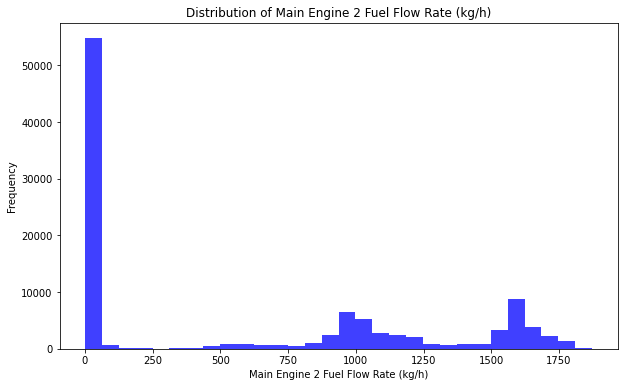

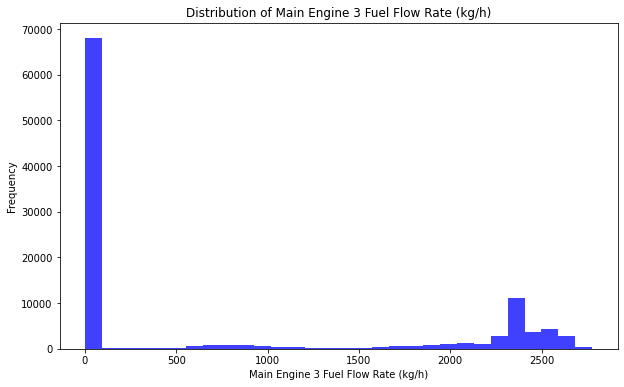

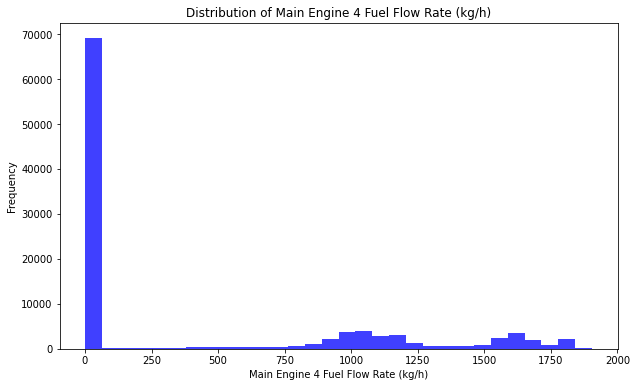

In [26]:
# Generates the distribution of the features in the dataset as histogram plots
feature_distribution(dfv)

**Comments (Vessel 1):**
1. Power Galleys: Mostly constant range of power consumption in operation. Less variation and wouldn't contribute much in forecast models
2. HVAC Chillers: A lot of variation, but extremely skewed in the sense that most of of the operation range is fixed
3. Scrubber Power: Shows 4 peaks, denoting 4 levels of high intensity cleaning activities
4. Power Service: Service Power is more uniformly distributed but doesn't have much variation in the data
5. Sea Temperature: Primarily influenced by the season of the year, and equitorial position of the ship, is uniformly distributed except for a peak on the right side indicating sligh skewness probably due to stronger summer season in one of the locations
6. Boiler Fuel Flow: Consists of a tall box and a tiny peak at the higher end of fuel flow rate. Most of the usual operations happen in between 0-10L/h fuel flow. Rarely, on days of extreme weather or rough operations
7. Incinerator: Majority of the waste removal operation happens with a lower fuel requirement, except for some extreme cases. These could be during docking for extra cleaning/occassional discharge cleaning.
8. Diesel Generators: Substantiate a 2-3 peaks highlighting a 2-3 modes of operation, including traveling against currents/winds requiring higher throughput
9. Latitude and Longitude: Positions indicate travel in the northern hemisphere, around Atlantic, with extra time spent close to the prime meridian
10. Relative Wind angle: Indicates that the cruise ship tries to move and orient itself in-line to the wind 0deg or 360deg for conserving energy by taking the momentum from wind and also by reducing drag
11. Depth: The cruise tries to maintain consistent depth throughout between 0-100 metres
12. Draft: maintained constantly between 7.5 and 8 metres, shows buoyancy control and build quality of the ship
13. Relative Wind Speed: The wind speed is aligned in favor to the ship movement by aligning the direction of sail
14. Speed through water/over land: Indicates 2 modes, one low rangee where the ship is either docking, anchoring or sailing in shallow waters. The second peak which is not so frequent indicates high speed motion. Among these, Speed through water has higher peak on greater end of speed spectrum because the ship has to move against the water many a times.
15. Trim: A uniform and normally distributed trim is maintained indicating well-planned design execution throughout the operation
16. Propulsion power has 4 peaks, indicating 4 ranges of operation. It is well spread out with variation, higher power being demanded probably when the ship is leaving from docks and is on shallow waters.
17. Thrusters: Limited operating ranges with 0-0.1 MW consumed in maneuvering primarily
18. Main Engine Fuel Flow: Is optimized to operate mostly at lower end without many fluctuations. This is indicated by a left skewed histogram, with only rare activities on the higher end

**Comments (Vessel2):**
In terms of feature distribution, vessel 2 replicates the same distribution for almost all the features, except latitude and longitude positions. Which indicates a different route. Beyond that, to look at specific differences between the features of the two vessels: a boxplot would be ideal!

In [38]:
# def feature_boxplot(df):
#     columns_to_plot = [col for col in df.columns if col not in ['Start Time', 'End Time', 'Vessel Name']]
    
#     # Create a boxplot for each column
#     for col in columns_to_plot:
#         plt.figure(figsize=(10, 6))
#         sns.boxplot(x='Vessel Name', y=col, data=df)
#         plt.title(f'Boxplot of {col} for Comparison between Vessels')
#         plt.xlabel('Vessel Name')
#         plt.ylabel(col)
#         plt.show()

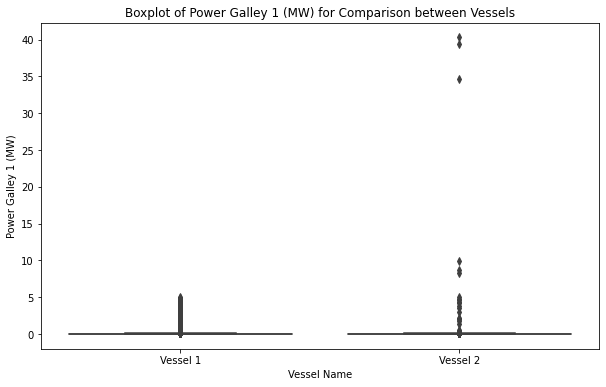

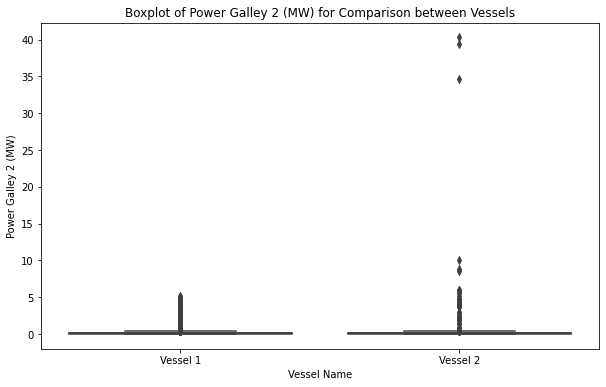

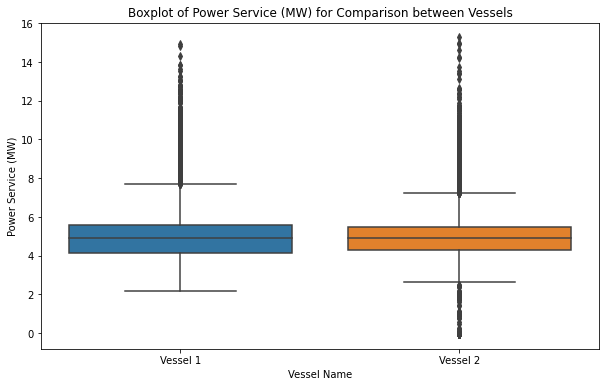

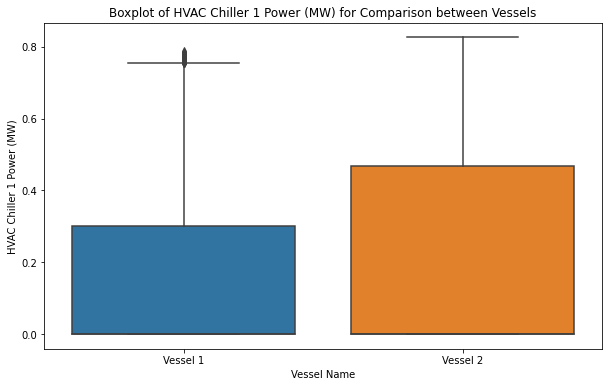

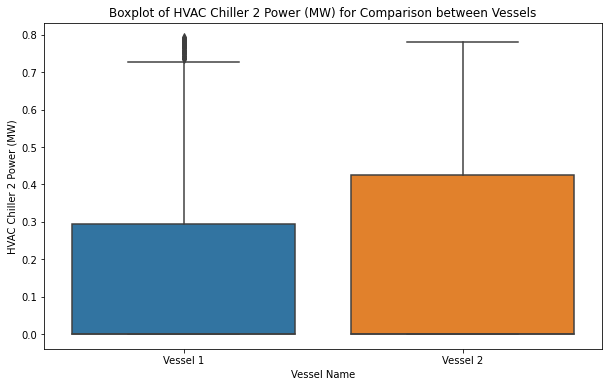

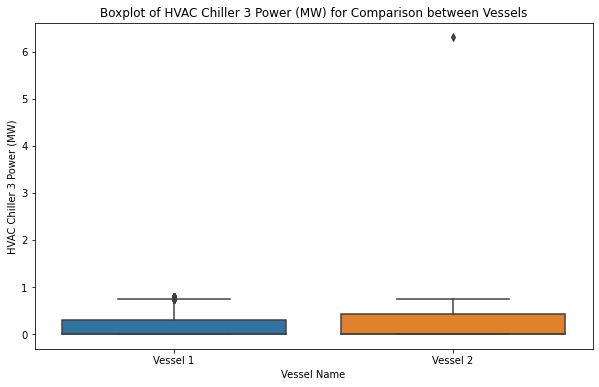

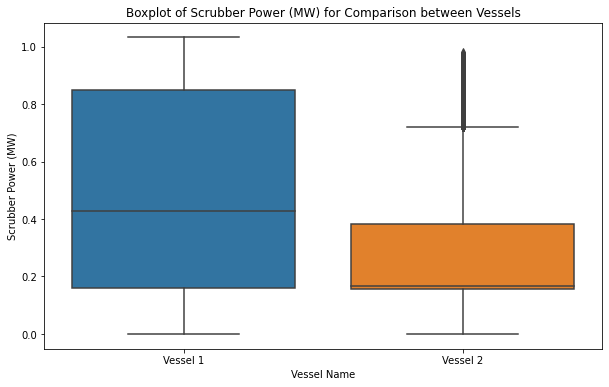

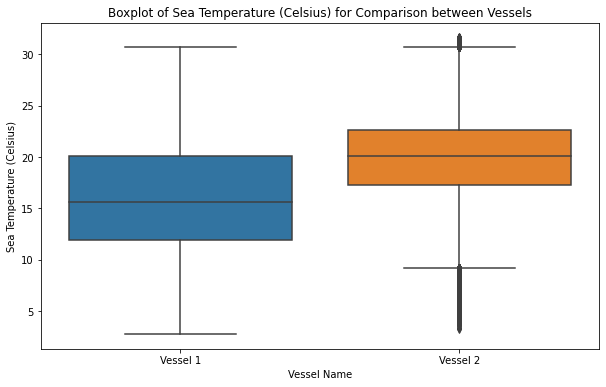

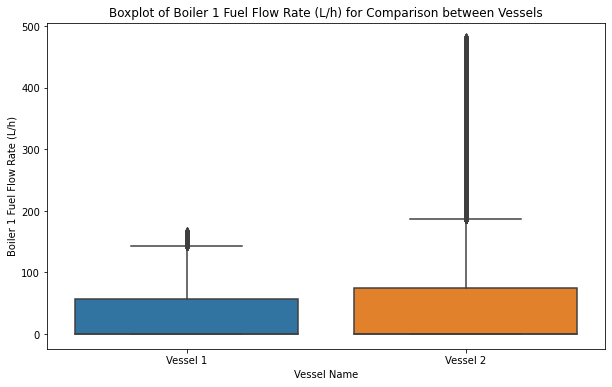

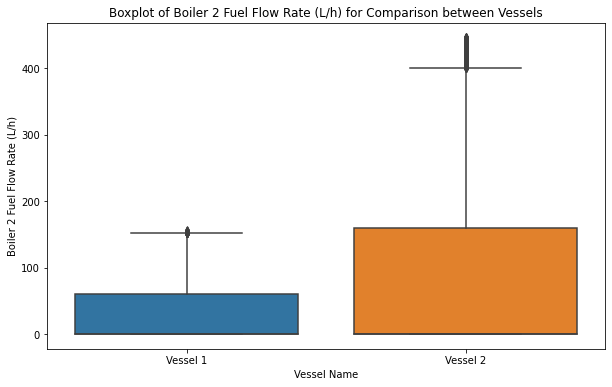

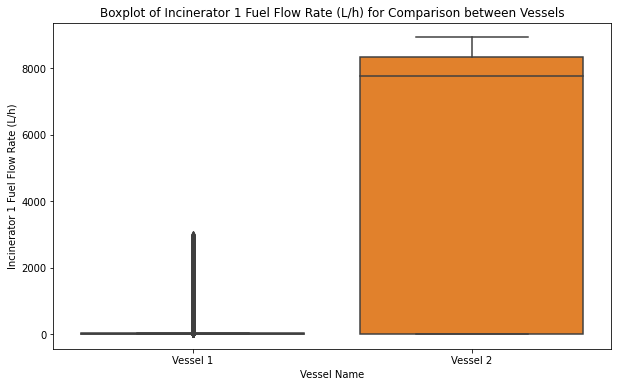

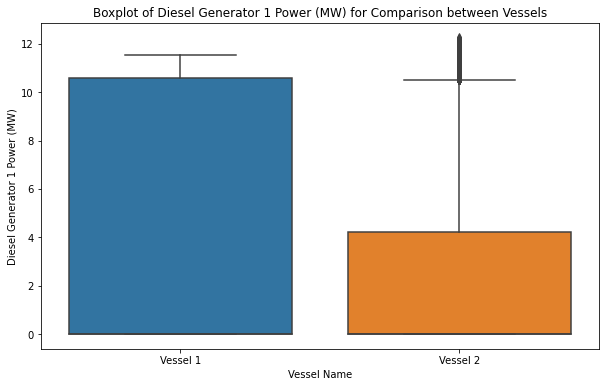

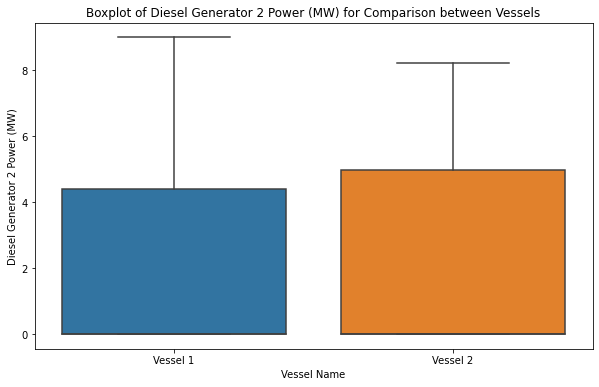

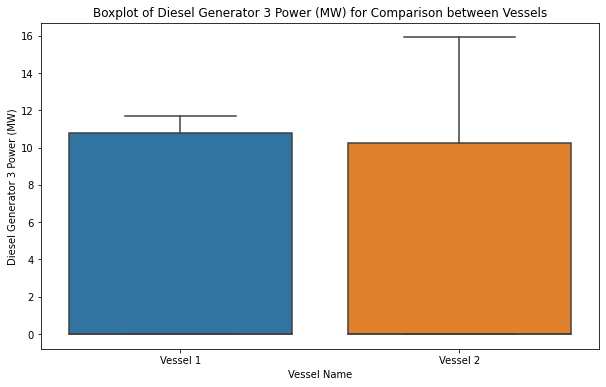

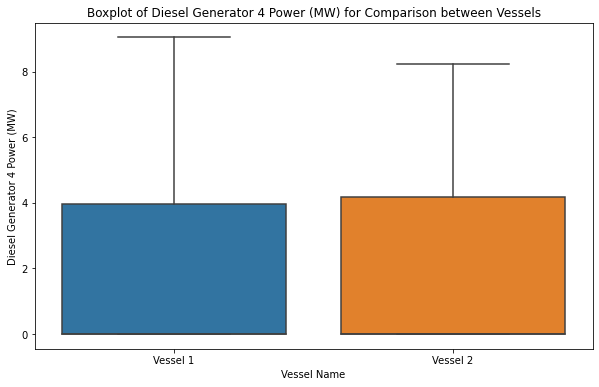

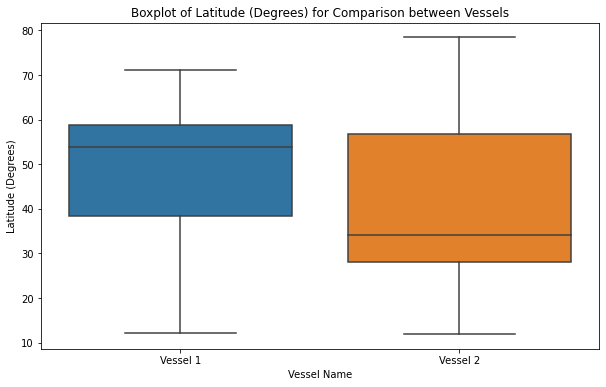

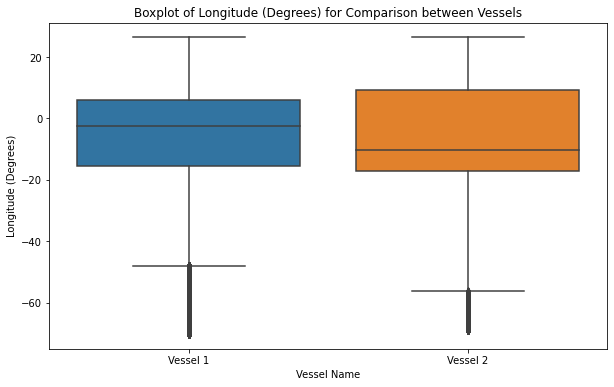

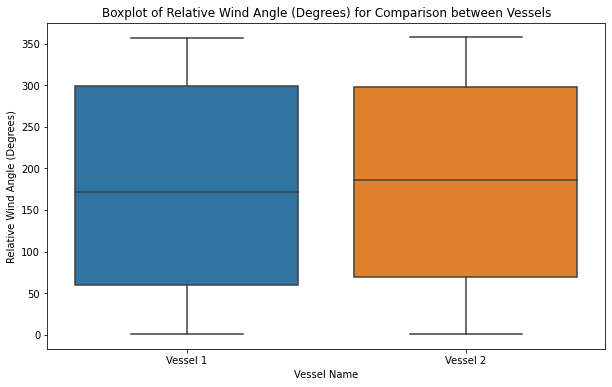

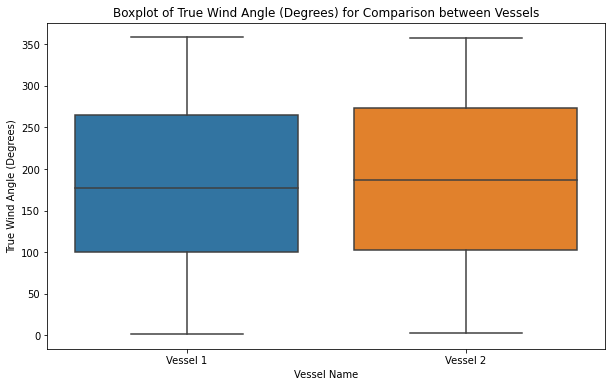

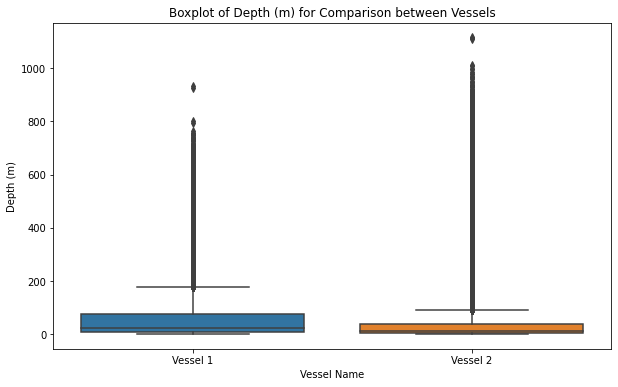

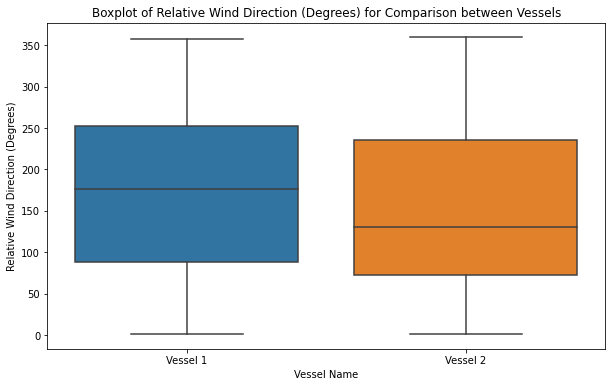

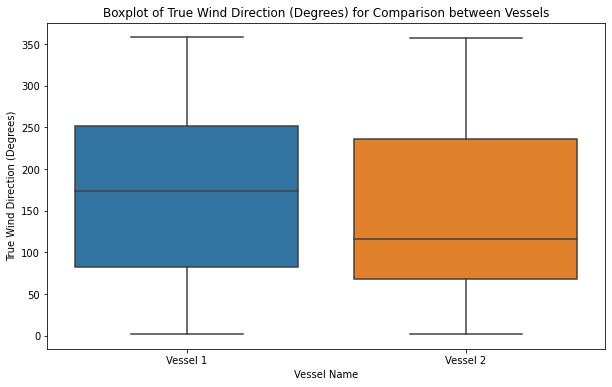

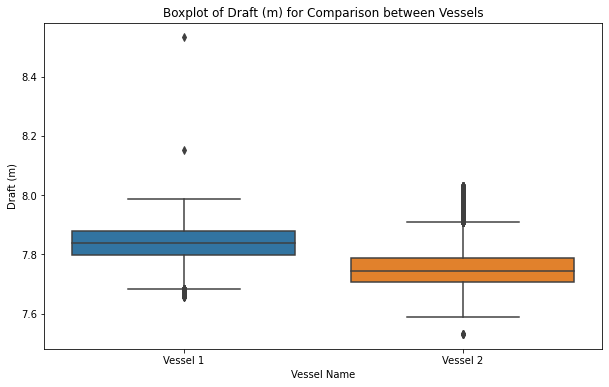

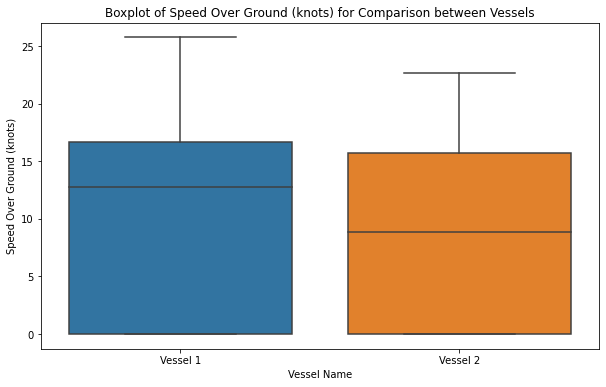

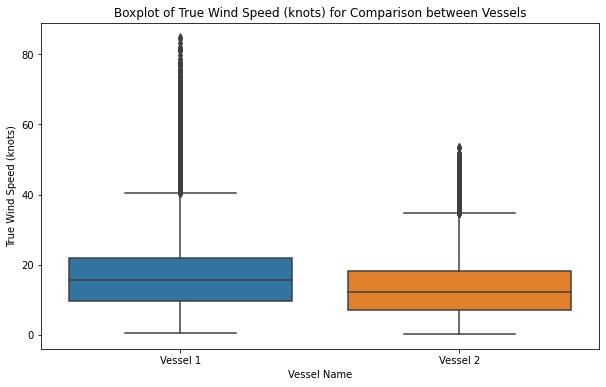

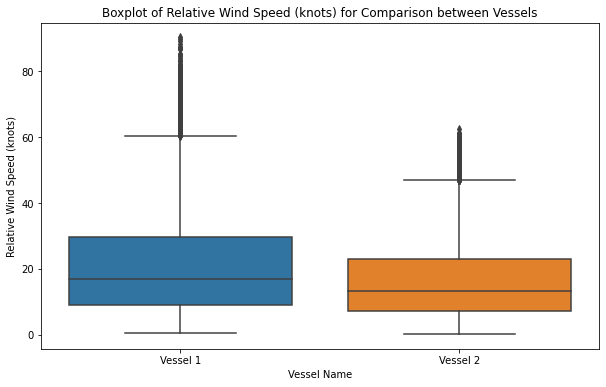

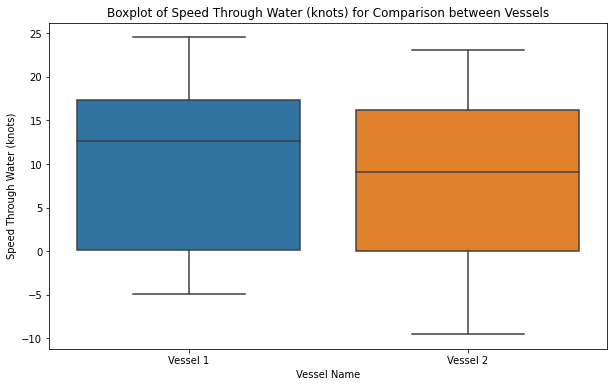

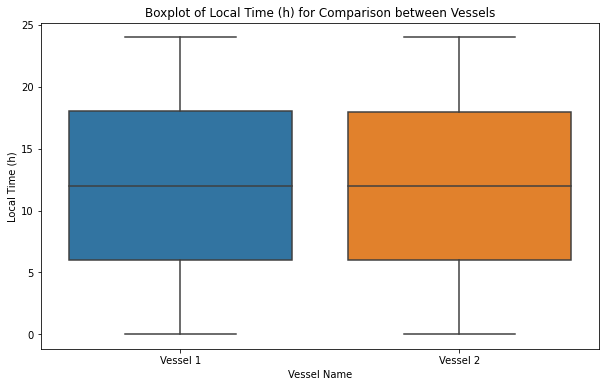

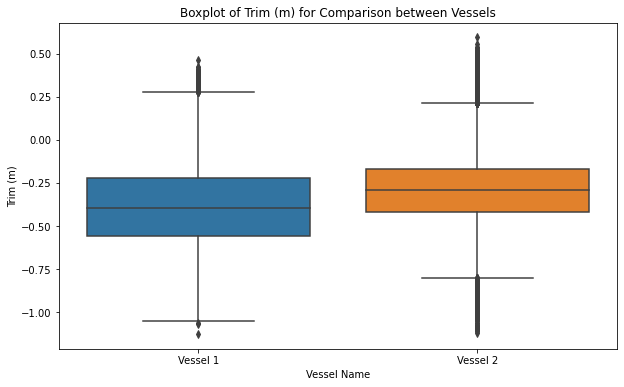

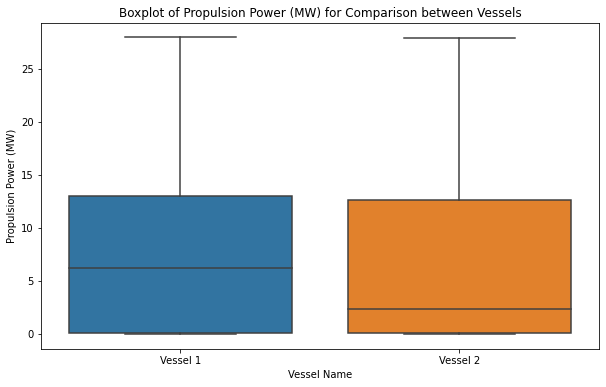

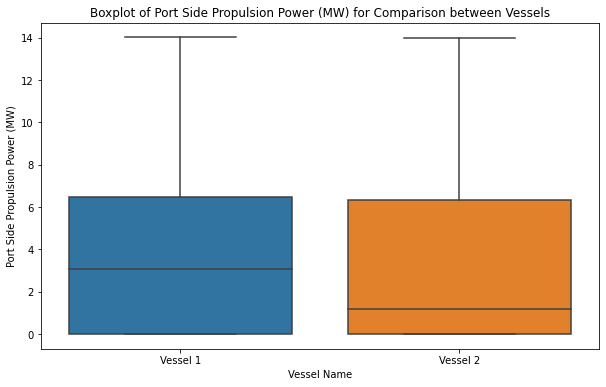

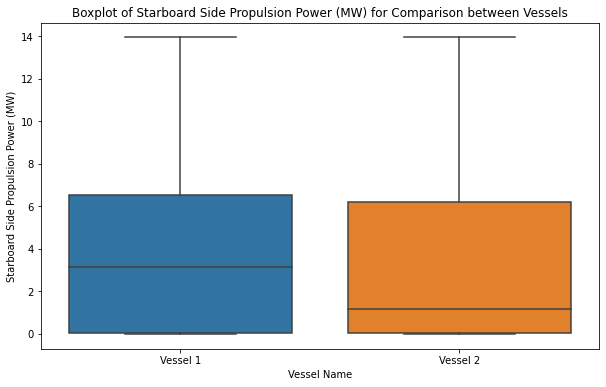

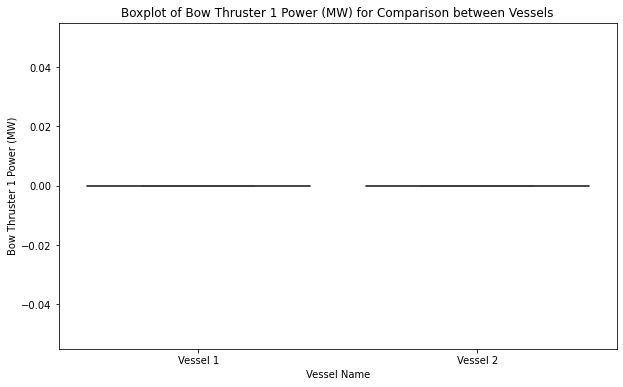

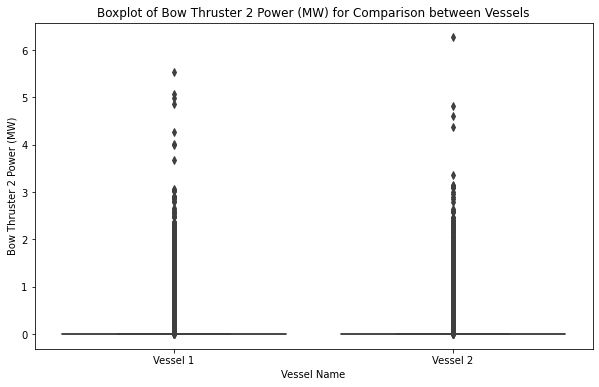

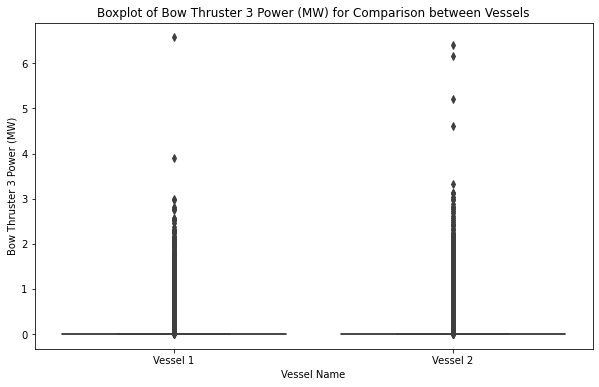

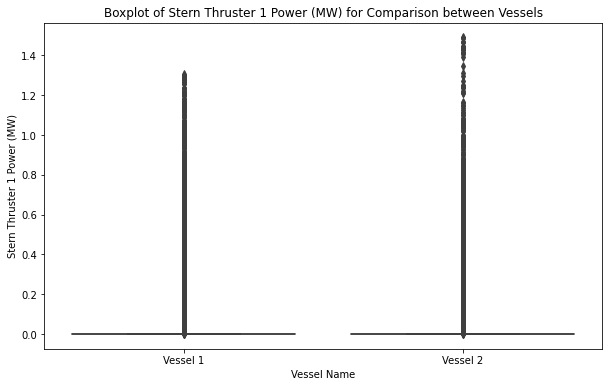

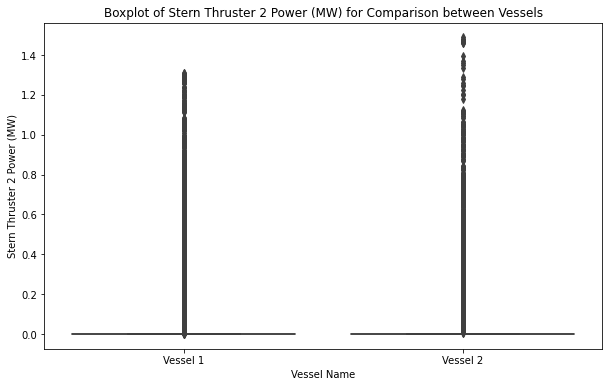

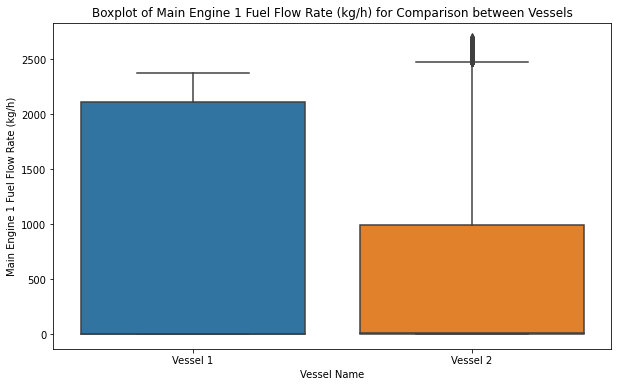

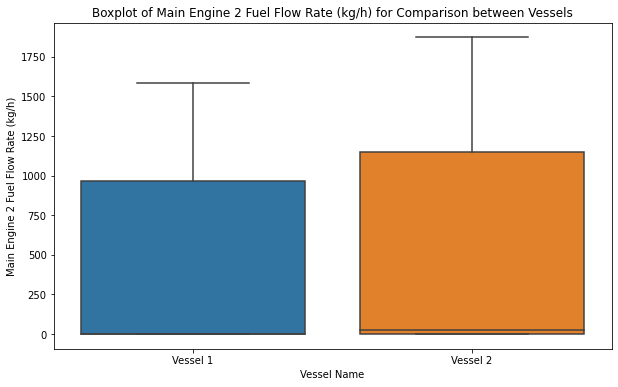

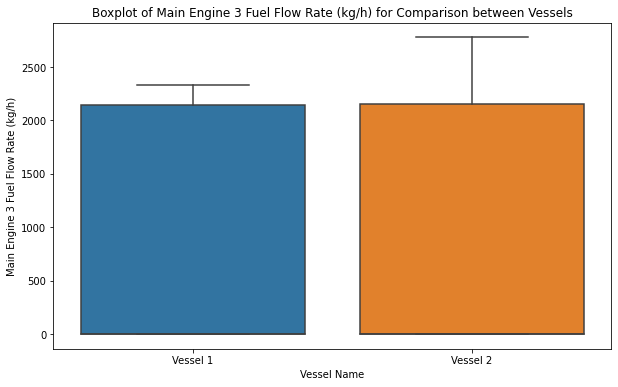

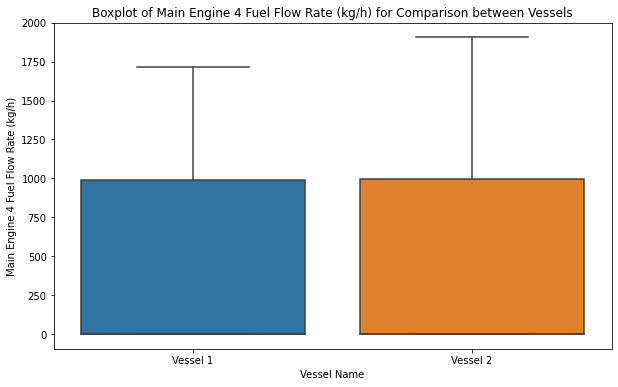

In [39]:
feature_boxplot(df)

As we can see, there are a few differences in operational parameters for the two vessels. Majorly, the median propulstion power indicated by a line in the body of the candle is lower for Vessel 2.
Meanwhile, there are many outliers in terms of Main engine fuel flow for vessel 2 and a larger variation within the body of the candle can be seen (1st quartile and 3rd quartile). The values are spread over a higher range of fuel flow.
With a lower median of propulsion power, this directly implies that the Power Specific Fuel Consumptions KPI, or the fuel required to produce a unit of power(efficiency) is much lower for vessel2.

<AxesSubplot:title={'center':'Missing Values'}>

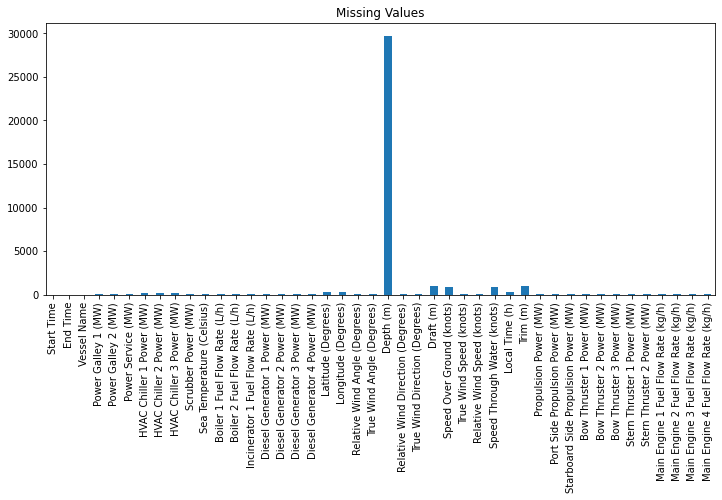

In [6]:
missing_values = dfv.isna().sum()
missing_values.plot(kind='bar',figsize=(12,5), title='Missing Values')  # Plot the missing values

### Impute the missing Values:
**Comments Vessel 1:**
1. For features that have <1%  missing values, impute by interpolating them using closest non-missing values as the features are all usually smooth within the 5mins time intervals in which they are recorded
2. For features that have >20% missing values, impute by using median of the column/feautre. The idea of using median is based on the skewed constant nature of depth maintained by the ship for most of the periods

**Comments Vessel 2:**
1. For features that have <1%  missing values, impute by interpolating them using closest non-missing values as the features are all usually smooth within the 5mins time intervals in which they are recorded
2. For features that have >20% missing values, impute by using median of the column/feautre
There are about 5-6 rows where all the values are empty except vessel name and timestamps. These rows can alternatively be removed from analysis. This is mostly a reporting error than a machine lapse, because a machine lapse and a sudden fluctuation between operational state and non-operational states is not possible within a 10-15 min time window. Also, in a later stage while resampling, they will have to be interpolated anyway. For the 'Depth' feature, a complete imputation with median/mean is necessary

In [7]:
# Imputing the missing values
missing_values

Start Time                                  0
End Time                                    0
Vessel Name                                 0
Power Galley 1 (MW)                        15
Power Galley 2 (MW)                        15
Power Service (MW)                         17
HVAC Chiller 1 Power (MW)                 206
HVAC Chiller 2 Power (MW)                 206
HVAC Chiller 3 Power (MW)                 206
Scrubber Power (MW)                        15
Sea Temperature (Celsius)                  15
Boiler 1 Fuel Flow Rate (L/h)              15
Boiler 2 Fuel Flow Rate (L/h)              15
Incinerator 1 Fuel Flow Rate (L/h)         15
Diesel Generator 1 Power (MW)              15
Diesel Generator 2 Power (MW)              15
Diesel Generator 3 Power (MW)              15
Diesel Generator 4 Power (MW)              15
Latitude (Degrees)                        340
Longitude (Degrees)                       340
Relative Wind Angle (Degrees)              14
True Wind Angle (Degrees)         

In [8]:
col_to_interpolate = dfv.columns.difference(['Depth (m)', 'Start Time', 'End Time', 'Vessel Name']) # Columns to interpolate

In [9]:
impute_time_series(dfv, col_to_interpolate) # Imputation via interpolation for the columns with < 1% missing values as they are likely to be continuous in time
dfv.isna().sum()

c:\Users\karth\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Start Time                                  0
End Time                                    0
Vessel Name                                 0
Power Galley 1 (MW)                         0
Power Galley 2 (MW)                         0
Power Service (MW)                          0
HVAC Chiller 1 Power (MW)                   0
HVAC Chiller 2 Power (MW)                   0
HVAC Chiller 3 Power (MW)                   0
Scrubber Power (MW)                         0
Sea Temperature (Celsius)                   0
Boiler 1 Fuel Flow Rate (L/h)               0
Boiler 2 Fuel Flow Rate (L/h)               0
Incinerator 1 Fuel Flow Rate (L/h)          0
Diesel Generator 1 Power (MW)               0
Diesel Generator 2 Power (MW)               0
Diesel Generator 3 Power (MW)               0
Diesel Generator 4 Power (MW)               0
Latitude (Degrees)                          0
Longitude (Degrees)                         0
Relative Wind Angle (Degrees)               0
True Wind Angle (Degrees)         

In [10]:
median_depth = dfv['Depth (m)'].median() # impution via median value as more than 20% of the values are missing
dfv['Depth (m)'].fillna(median_depth, inplace=True)
dfv.isna().sum()

c:\Users\karth\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Start Time                              0
End Time                                0
Vessel Name                             0
Power Galley 1 (MW)                     0
Power Galley 2 (MW)                     0
Power Service (MW)                      0
HVAC Chiller 1 Power (MW)               0
HVAC Chiller 2 Power (MW)               0
HVAC Chiller 3 Power (MW)               0
Scrubber Power (MW)                     0
Sea Temperature (Celsius)               0
Boiler 1 Fuel Flow Rate (L/h)           0
Boiler 2 Fuel Flow Rate (L/h)           0
Incinerator 1 Fuel Flow Rate (L/h)      0
Diesel Generator 1 Power (MW)           0
Diesel Generator 2 Power (MW)           0
Diesel Generator 3 Power (MW)           0
Diesel Generator 4 Power (MW)           0
Latitude (Degrees)                      0
Longitude (Degrees)                     0
Relative Wind Angle (Degrees)           0
True Wind Angle (Degrees)               0
Depth (m)                               0
Relative Wind Direction (Degrees) 

In [ ]:
dfv.head()

### Multi-Collinearity Check

In [11]:
# Correlation matrix
dfv_sub = dfv.iloc[:,3:]
corr = dfv_sub.corr()

In [ ]:
high_corr = []
for i in corr.columns:
    high_corr.append(corr[(corr[i] > 0.8) | (corr[i] < -0.8)][i])
print(f'The highly correlated columns are:{high_corr}')

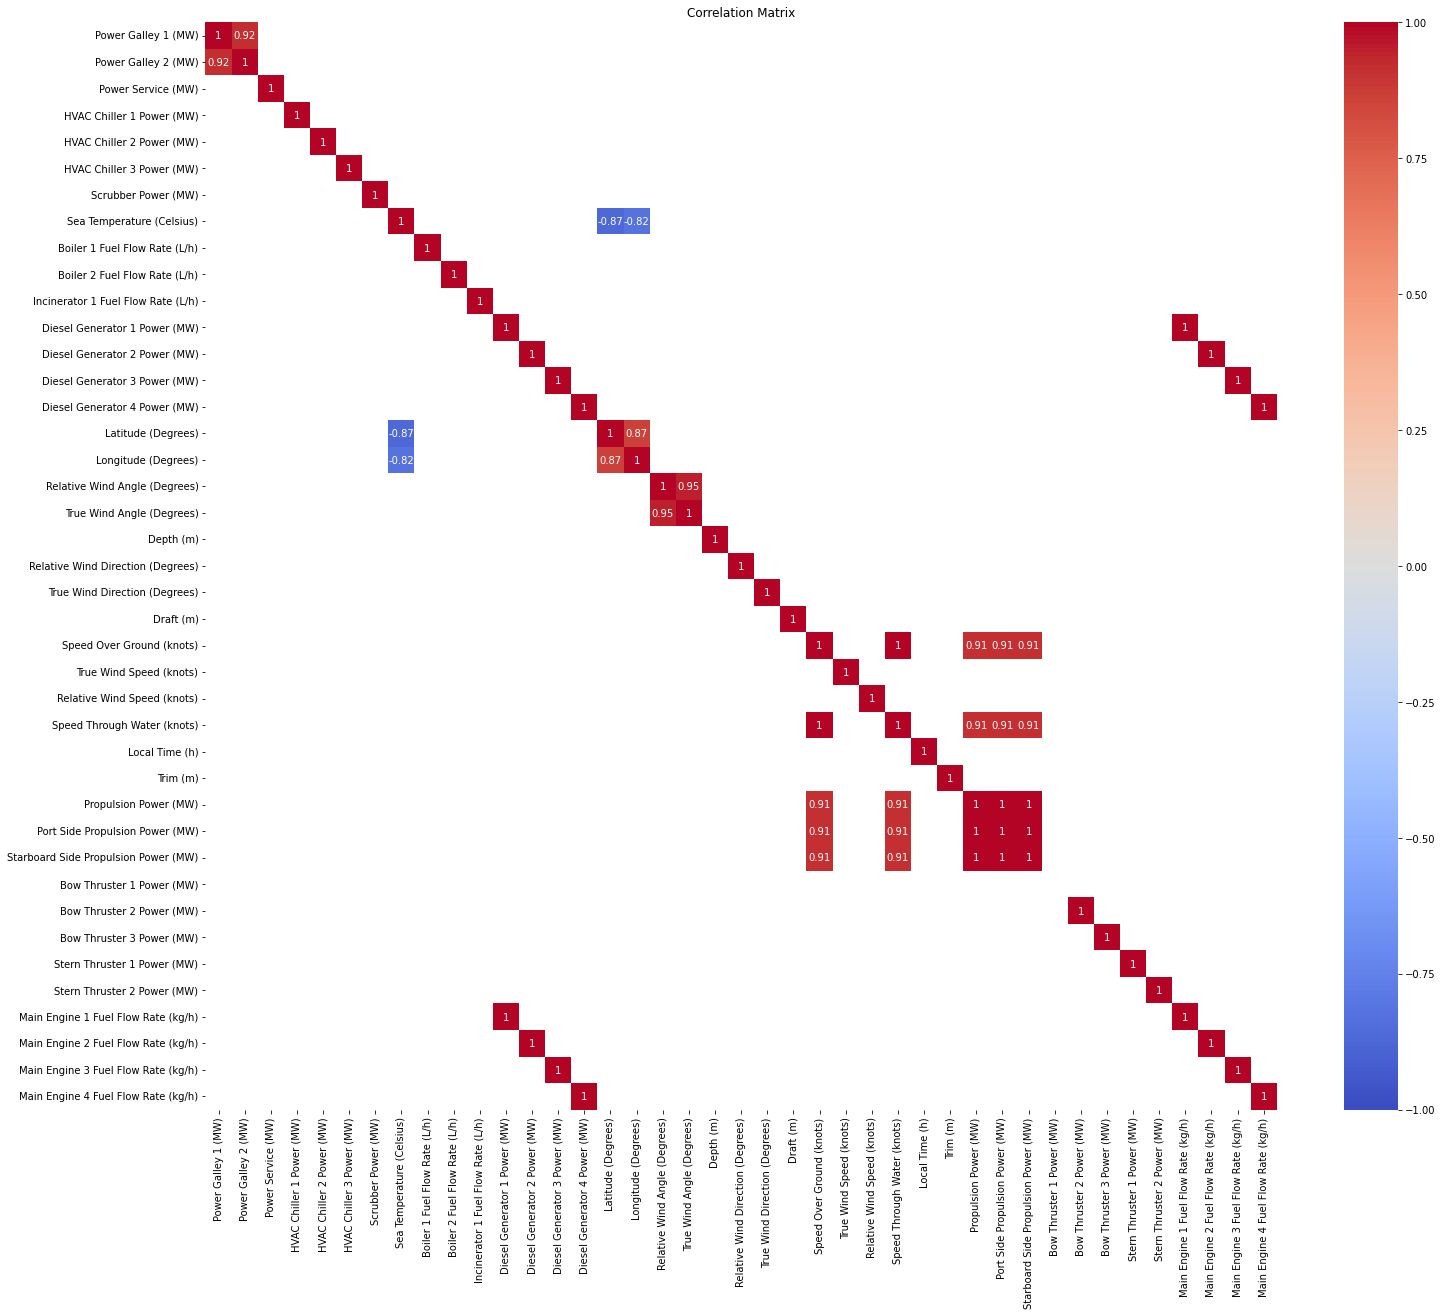

In [12]:
# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(24,20))
sns.heatmap(data = corr[(corr > 0.8) | (corr < -0.8)], vmin=-1,vmax=1, cmap='coolwarm', ax = ax, annot= True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Correlation Matrix')
plt.show()

**Comments (Vessel 1):**
1. Diesel Generators' Power are highly correlated to corresponding Main Engine's Fuel flow rate 
2. Propulsion power is a linear combination of Port Side Propulsion Power and Starboard Side Propulsion Power 
3. Speed through water and Speed over ground are positively correlated to the Propulsion Power
4. Sea water temperature reducing as the latitude is increasing completely makes sense. This is because, temperatures are lower as one moves towards the poles

**Comments (Vessel 2):**
1. Diesel Generators' Power are highly correlated to corresponding Main Engine's Fuel flow rate (=1) 
2. Propulsion power is a linear combination of Port Side Propulsion Power and Starboard Side Propulsion Power 
3. Speed through water and Speed over ground are positively correlated to the Propulsion Power (=0.91)
4. Sea water temperature reducing as the latitude is increasing completely makes sense. This is because, temperatures are lower as one moves towards the poles. Longitude is also negatively correlated to sea temperatures


### Trend and seasonality analysis
The outliers and skewness in the data are kept for analysis as this is recorded first hand. For forecasting the data will be standardized but now the analysis is done as is

In [13]:
# Resampling the data for hourly, daily, weekly and seasonal trends
hourly_df, daily_df, weekly_df, monthly_df = resample(dfv)

c:\DDS\Track_DS\git\Cruise_Performance_Analysis\trends.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Start Time'] = pd.to_datetime(data['Start Time'])


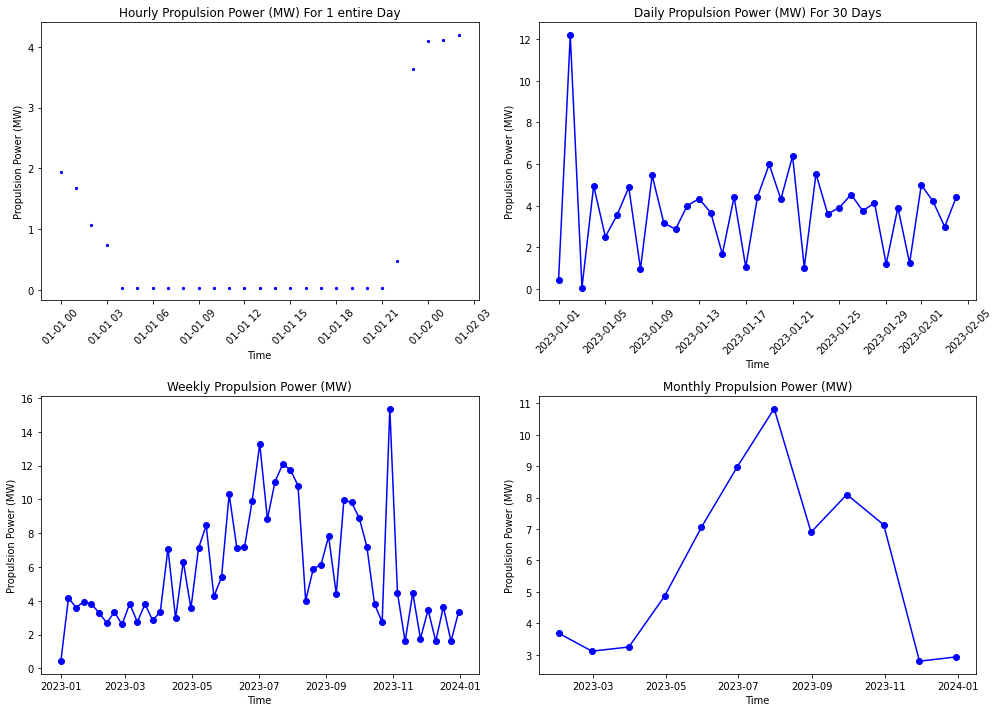

In [14]:
# Pick a feature from the list above to visualize the trend over
trend_plot(hourly_df, daily_df, weekly_df, monthly_df, 'Propulsion Power (MW)')

**Comments (Vessel 1):**
- 'Propulsion Power (MW)' vs 'Relative Wind Speed (knots)': Extreme Wind speeds demand more propulsion power, indicating the ship having to re-direct itself or move against the wind
- 'Latitude' vs 'Relative Wind Speed (knots)': No visible relationship between Latitude and Relative wind Speeds

**Comments (Vessel 2):**
- 'Propulsion Power (MW)' vs 'Relative Wind Speed (knots)': Extreme Wind speeds demand more propulsion power, which is clearly indicated in the plots as the ship having to re-direct itself or move against the wind
- 'Latitude' vs 'Relative Wind Speed (knots)': No visible relationship between Latitude and Relative wind Speeds

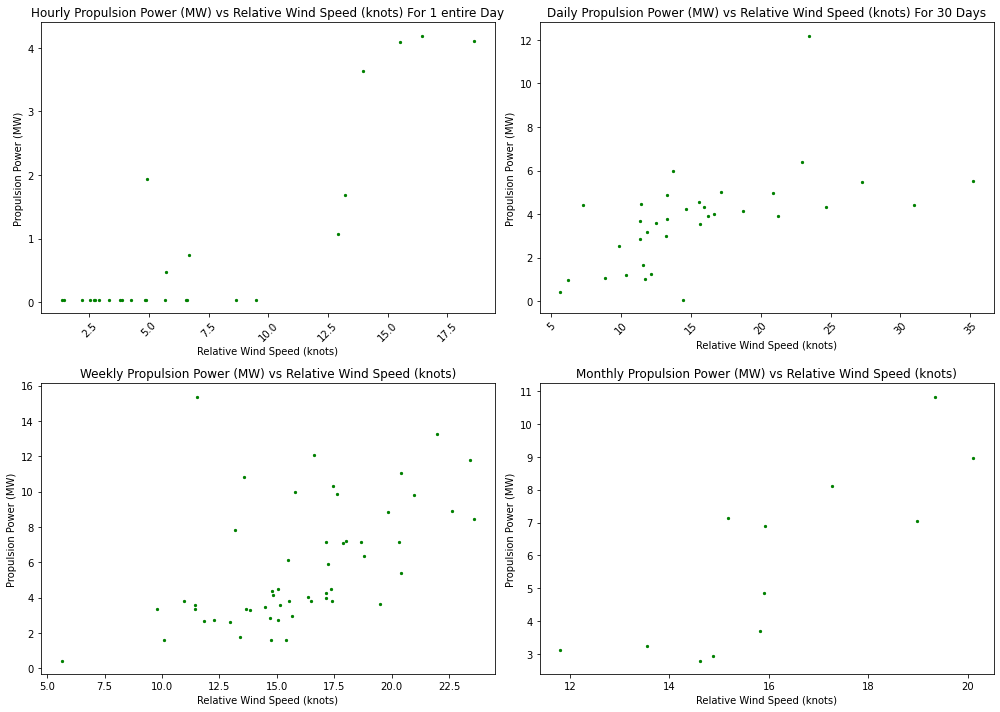

In [27]:
# Pick 2 features from the above list to visualize their relationship with each other over time
pair_plot(hourly_df, daily_df, weekly_df, monthly_df, 'Propulsion Power (MW)', 'Relative Wind Speed (knots)')

**Comments (Vessel 1):**
- 'Propulsion Power (MW)' vs 'Relative Wind Speed (knots)': Extreme Wind speeds demand more propulsion power, indicating the ship having to re-direct itself or move against the wind
- 'Latitude' vs 'Relative Wind Speed (knots)': No visible relationship between Latitude and Relative wind Speeds

**Comments (Vessel 2):**
- 'Propulsion Power (MW)' vs 'Relative Wind Speed (knots)': Extreme Wind speeds demand more propulsion power, which is clearly indicated in the plots as the ship having to re-direct itself or move against the wind
- 'Latitude' vs 'Relative Wind Speed (knots)': No visible relationship between Latitude and Relative wind Speeds

### KPI Generation and Analysis
3 KPIs are generated based on domain knowledge and research (check the Energy Flow Diagram I built on the README):
1. Fuel Consumption per nautical mile ( A measure of fuel efficiency)
2. Total Power Consumed
3. Power Specific Fuel Consumption

**Method**
- Fuel Consumption per nautical mile = Sum of Engine Fuel Flow / Speed through water. It is capped at a maximum of 5000, because it goes to infinity when speed through is very close to 0. This happens while docking and anchoring
- Total Power Consumed = Sum power consumed by Power Galleys, HVAC Chillers, Power Service, Scrubber, Propulsion and Thrusters
- Power Specific Fuel Consumption = Fuel flow in engines, boilers and incinerator/ Total power consumed. Similar to the very commonly used fuel efficiency or brake specific fuel consumption (BSFC). It is used to assess the efficiency of any engine that burns fuel and produces rotational power, typically internal combustion engines. Assuming Fuel in Boiler and Incinerator to be Diesel and the density to be 0.85 kg/litre, for mass flow calculation.

In [17]:
# Compute the KPIs at hourly level
h_kpi = compute_kpis(hourly_df)

In [20]:
h_kpi['Fuel Consumption per nautical mile'].describe()

count    8760.000000
mean     2284.289325
std      1423.459336
min         0.000000
25%      1088.990174
50%      1666.172118
75%      3855.283768
max      5000.000000
Name: Fuel Consumption per nautical mile, dtype: float64

In [18]:
# Compute KPIS for daily, weekly and monthly granular data
d_kpi = compute_kpis(daily_df)
w_kpi = compute_kpis(weekly_df)
m_kpi = compute_kpis(monthly_df)

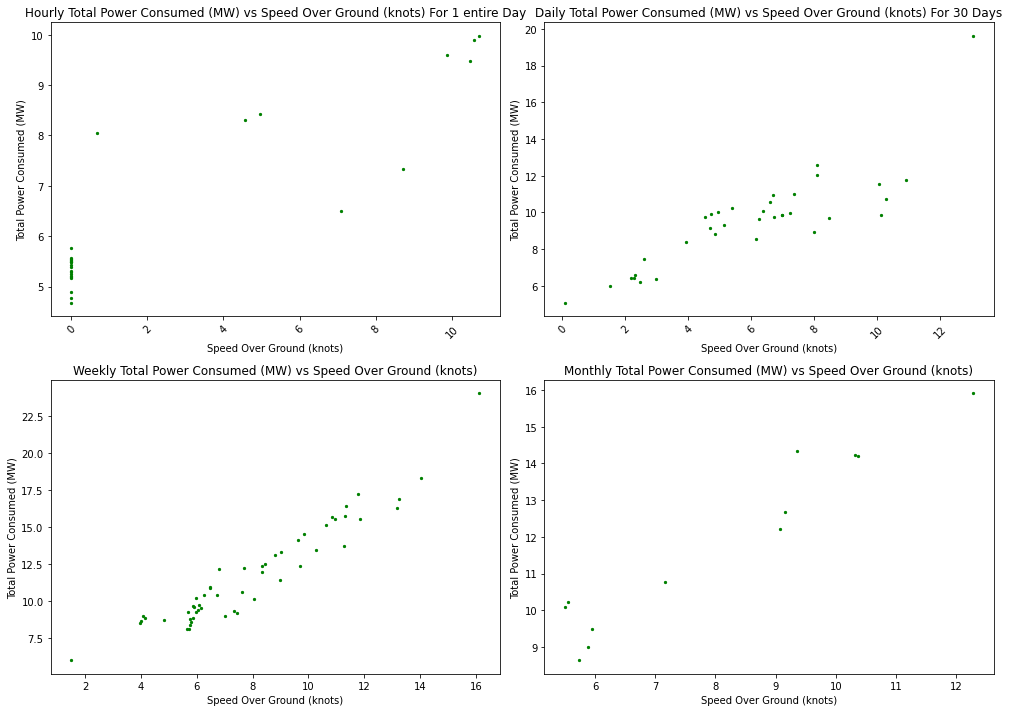

In [19]:
pair_plot(h_kpi, d_kpi, w_kpi, m_kpi, 'Total Power Consumed (MW)', 'Speed Over Ground (knots)')

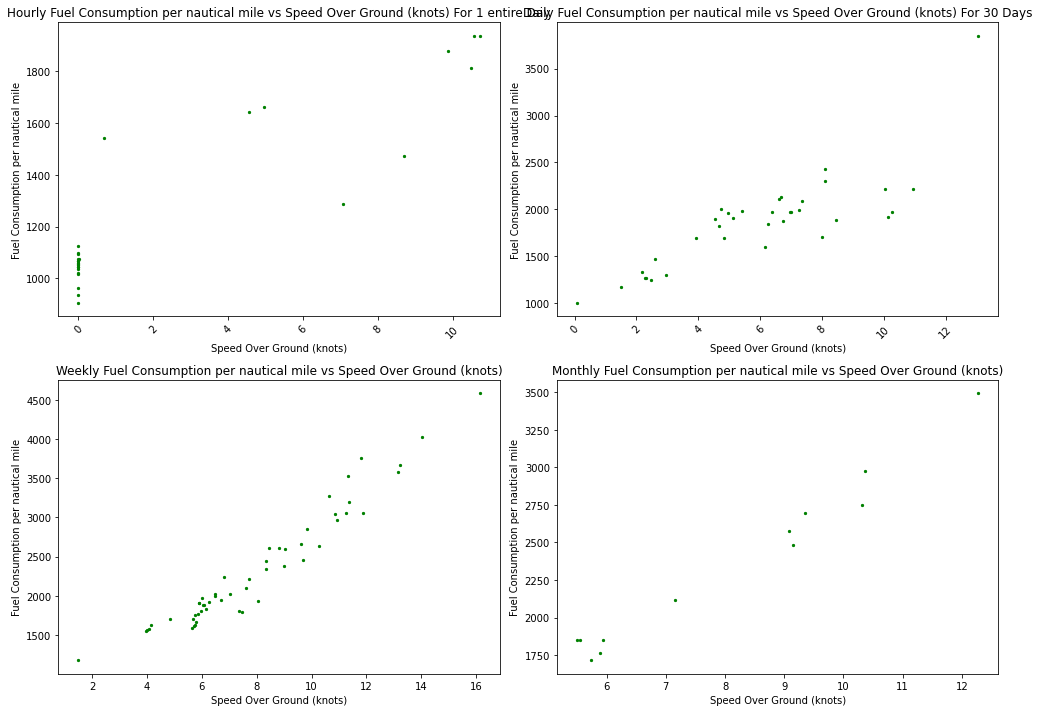

In [21]:
pair_plot(h_kpi, d_kpi, w_kpi, m_kpi, 'Fuel Consumption per nautical mile', 'Speed Over Ground (knots)')

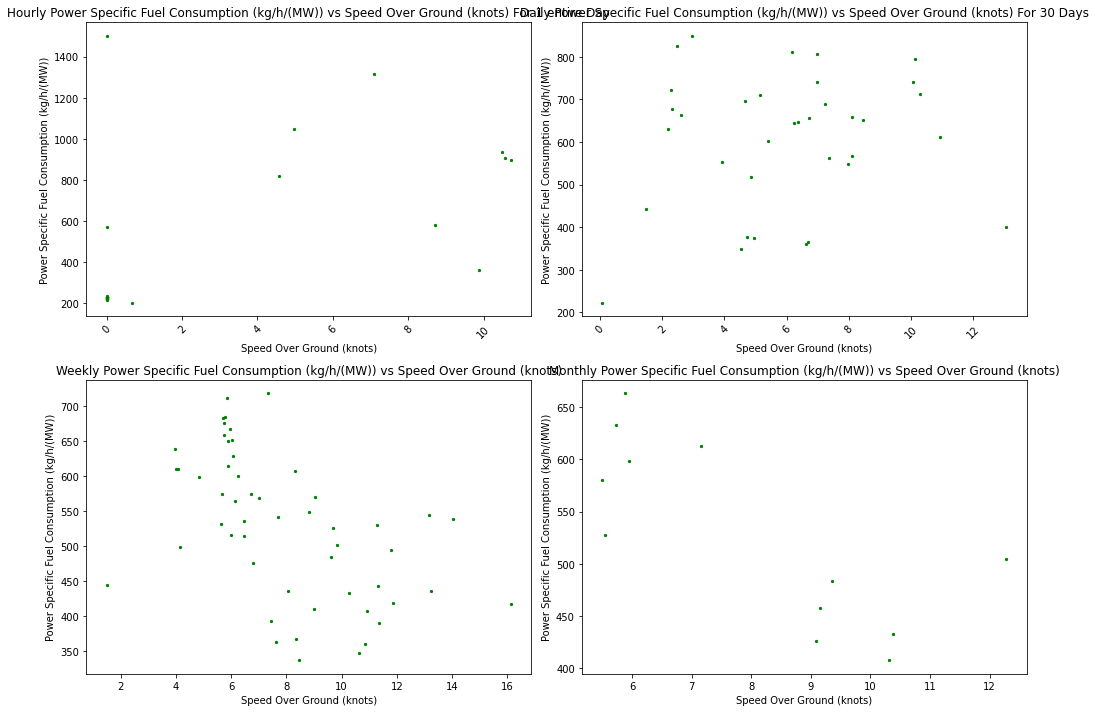

In [28]:
pair_plot(h_kpi, d_kpi, w_kpi, m_kpi, 'Power Specific Fuel Consumption (kg/h/(MW))', 'Speed Over Ground (knots)')

**Comments(Vessel 1):**
1. KPIs vs Sea Temperature
- On the long-term front, with seasonality in play: we can observe from the monthly chart that for warmer conditions of water, more power is consumed. 
- This totally makes sense as the water would be less dense and the ship would have to work generate thrust to move through it
- The effect is not fully observed in the Fuel Efficiency chart as lower density also means lower resistance to move through water. 
2. KPIs vs Speed over Ground
- Total Power Required increases with Speed over Ground
- Fuel Consumption per nautical mile has two clusters where there is not much increase in Fuel required per nautical mile (between 6&8, 12&17)
- Coming to Power Specific Fuel Consumption, the optimal speeds again lie between 12 and 17 where ther Fuel required to produce a certain power is flat and considerably low

Based on the scatter plots, the optimal speed of operation are betweent 7.5-8.5 and 15-17.5, where there is a horizontal spread of points: the fuel required to operate in these range of speeds seem to be the same and not fluctuate a lot

**Comments(Vessel 2):**
1. KPIs vs Sea Temperature
- On the long-term front, with seasonality in play: we can observe from the monthly chart that for warmer conditions of water, more power is consumed. 
- This totally makes sense as the water would be less dense and the ship would have to work generate thrust to move through it
- The effect is not fully observed in the Fuel Efficiency chart as lower density also means lower resistance to move through water. 
2. KPIs vs Speed over Ground
- Total Power Required increases with Speed over Ground
- Fuel Consumption per nautical mile has increases consistently with speed (between 6&8, 12&17)
- Coming to Power Specific Fuel Consumption, no visible pattern can be seen

### Time-Series Forecasts
1. I first remove the columns not necessary for analysis like 'End Time' and 'Vessel Name'
2. Further, from the above analysis it is also determined that some columns are very highly correlated. If two columns are correlated at > 0.9, only one is kept for the analysis
3. If the distribution of a column is very narrow, it doesn't offer any variation as a feature. Hence we remove that also from the analysis
4. None of the features used to generate the KPI can be used for forecasting as it will be linearly dependant by inherent nature
5. Therefores, in the SARIMAX Seasonal modeling and forecast, I take an approach to try and forecast the total power from external factors that can be pre-planned before the cruise starts based on weather forecasts and other requirements
6. Finally, this is concluded with some simple hyperparameter tuning for better AIC value (Penalizing method for addition of a new feature to the model) to get the best performing forecast

Hourly will be too granular and computationally expensive. Monthly analysis would be sparse and not so informative since we only have 1 year data

**External factors that can be pre-planned before the cruise starts**

['Sea Temperature (Celsius)', 'Latitude (Degrees)', 'Longitude (Degrees)', 'Relative Wind Angle (Degrees)', 'True Wind Angle (Degrees)', 'Depth (m)', 'Relative Wind Direction (Degrees)', 'True Wind Direction (Degrees)', 'Draft (m)',
    'Speed Over Ground (knots)', 'True Wind Speed (knots)', 'Relative Wind Speed (knots)', 'Local Time (h)', 'Trim (m)', 'Total Power Consumed (MW)']

In [ ]:
# Hourly forecast, the grid search for hyperparameters takes a long time to run, processor limitations
h_forecast = h_kpi[['Sea Temperature (Celsius)', 'Latitude (Degrees)', 'Longitude (Degrees)', 'Relative Wind Angle (Degrees)', 'True Wind Angle (Degrees)', 'Depth (m)', 'Relative Wind Direction (Degrees)', 'True Wind Direction (Degrees)', 'Draft (m)',
       'Speed Over Ground (knots)', 'True Wind Speed (knots)', 'Relative Wind Speed (knots)', 'Local Time (h)', 'Trim (m)', 'Total Power Consumed (MW)']]

In [22]:
# Daily forecast
d_forecast = d_kpi[['Sea Temperature (Celsius)', 'Latitude (Degrees)', 'Longitude (Degrees)', 'Relative Wind Angle (Degrees)', 'True Wind Angle (Degrees)', 'Depth (m)', 'Relative Wind Direction (Degrees)', 'True Wind Direction (Degrees)', 'Draft (m)',
       'Speed Over Ground (knots)', 'True Wind Speed (knots)', 'Relative Wind Speed (knots)', 'Local Time (h)', 'Trim (m)', 'Total Power Consumed (MW)']]

SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:2466.43414687792
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:2153.218142361157
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:1438.9806283535427
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:1270.7253525129752
SARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:1493.5296078942602
SARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:1327.6275777890983
SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:1333.6805211253009
SARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:1270.4005895897901
SARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:2122.759336521911
SARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:1940.4079467097677
SARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:1436.0557082031394
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:1270.3890194688868
SARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:1487.4669566779003
SARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:1325.8752429166555
SARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:1331.6490292233977
SARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:1270.1921364798154
SARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:1437.2777679240858
SARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:1439.2711491927419
SARIMA(0, 1, 0)x(0, 1, 0, 7) - A

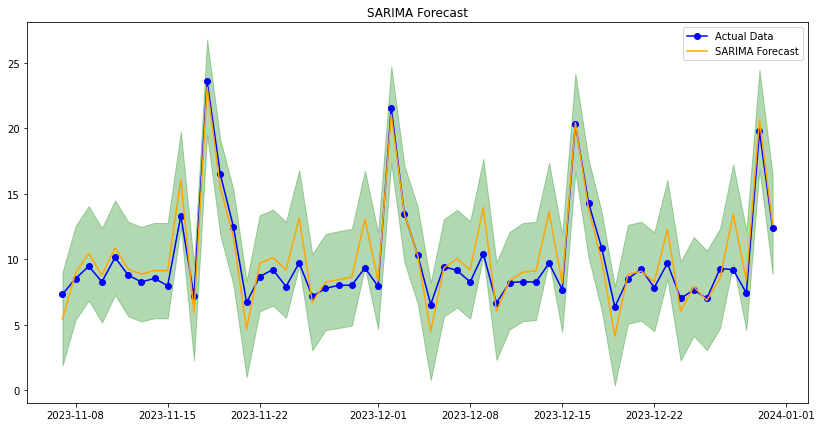

In [23]:
sarimax_forecast(d_forecast, 'Total Power Consumed (MW)', 7) #7 day forecast

**Comments Vessel 1: Power- Daily**
- For the dataset on a daily level granularity, Total power consumption for the cruise ship can be forecasted within acceptable margin of errors. The 95% confidence range of forecast is also predicted. The true range almost always lies in the 95% confidence range of forecast.
- This is by using external factors only, without taking into account any operational component. Therefore it states that the external conditions can forecast the energy requirements for the ship, this can aid in early resource planning of cruises
- Best SARIMA(1, 1, 1)x(0, 0, 0, 7) - AIC:1330.37243216749
- RMSE:  2.616105733879915 (MW)

**Comments Vessel 2: Power- Daily**
- For the dataset on a daily level granularity, Total power consumption for the cruise ship can be forecasted better than for vessel 1 in terms of AIC and R2 values. The 95% confidence range of forecast is also predicted. The true range almost always lies in the 95% confidence range of forecast.
- This is by using external factors only, without taking into account any operational component. Therefore it states that the external conditions can forecast the energy requirements for the ship, this can aid in early resource planning of cruises
- Best SARIMA(1, 0, 1)x(0, 1, 1, 7) - AIC:1268.9562687277244
- RMSE:  1.5000476299191863 (MW)
- R2 Score:  0.8428713947731085

In [24]:
d_forecast_fuel = d_kpi[['Fuel Consumption per nautical mile', 'Total Power Consumed (MW)']]

In [ ]:
d_forecast_fuel.head()

SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:5713.1786073662015
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:5366.569629841638
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:4106.973018155
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:4018.1122087915605
SARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:4236.422209406897
SARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:4147.800242337898
SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:4024.7178323107846
SARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:4019.8158208428868
SARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:5333.398323897751
SARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:5096.2637898964485
SARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:4097.966115174111
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:3994.338130576566
SARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:4235.648830466167
SARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:4139.439210109653
SARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:4003.480393134943
SARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:3996.123061299912
SARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:4121.720585349037
SARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:4123.634166806178
SARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:4232.7563

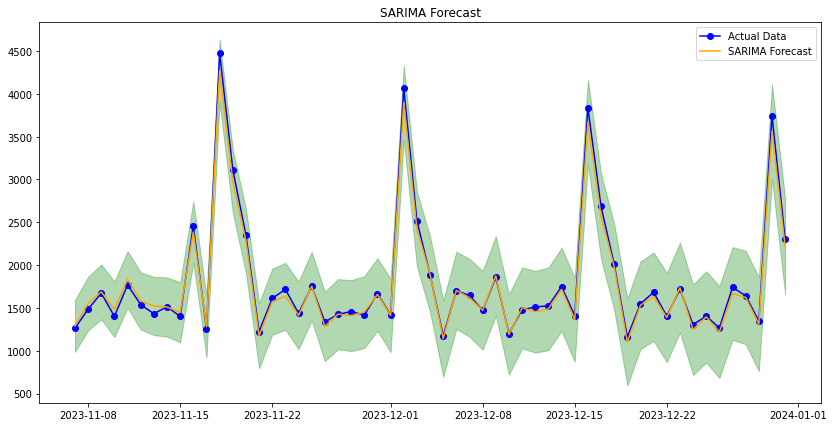

In [25]:
sarimax_forecast(d_forecast_fuel, 'Fuel Consumption per nautical mile', 7)

**Comments for Vessel 1: Fuel Consumption per nautical mile**
- For the dataset on a daily level granularity, Fuel Consumption per nautical mile for the cruise ship can be forecasted just using the Total power consumption data within acceptable range of errors. The 95% confidence range of forecast is also predicted. The true range almost always lies in the 95% confidence range of forecast. The 95% range in this case is also narrow, that shows more certainity and less variance in predictions.
- This means, if an accurate enough forecast can be made for the power requirements, the forecast can in turn can be used for fuel requirements of the cruise ship. Therefore it states that the external conditions can forecast the fuel planning requirements for the ship, this can aid in early duel planning of cruises, with potential for entering trade positions.
- Best SARIMA(1, 1, 1)x(0, 1, 1, 7) - AIC:3924.477617510145
- RMSE:  161.68641766048893 (kg/h/knots)

**Comments for Vessel 2: Fuel Consumption per nautical mile**
- For the dataset on a daily level granularity, Fuel Consumption per nautical mile for the cruise ship 2 can be forecasted just using the Total power consumption data within acceptable range of errors. The 95% confidence range of forecast is also predicted. The true range almost always lies in the 95% confidence range of forecast. The 95% range in this case is also narrow, that shows more certainity and less variance in predictions.
- In this case the forecast is better than for Vessel 1 in terms of the AI and R2 values, the forecast can in turn can be used for fuel requirements of the cruise ship. Therefore it states that the external conditions can forecast the fuel planning requirements for the ship, this can aid in early duel planning of cruises, with potential for entering trade positions.
- Best SARIMA(1, 1, 1)x(0, 1, 1, 7) - AIC:3931.2154674475537
- RMSE:  70.80014247972981
- R2 Score:  0.990756819854504

In [ ]:
best_forecast(d_forecast_fuel, 'Fuel Consumption per nautical mile', [1,1,1],[0,1,1,7])

In [29]:
# Weekly Forecast model
w_forecast = w_kpi[['Sea Temperature (Celsius)', 'Latitude (Degrees)', 'Longitude (Degrees)', 'Relative Wind Angle (Degrees)', 'True Wind Angle (Degrees)', 'Depth (m)', 'Relative Wind Direction (Degrees)', 'True Wind Direction (Degrees)', 'Draft (m)',
       'Speed Over Ground (knots)', 'True Wind Speed (knots)', 'Relative Wind Speed (knots)', 'Local Time (h)', 'Trim (m)', 'Total Power Consumed (MW)']]

SARIMA(0, 0, 0)x(0, 0, 0, 4) - AIC:381.9437546173265
SARIMA(0, 0, 0)x(0, 0, 1, 4) - AIC:334.7610455801101
SARIMA(0, 0, 0)x(0, 1, 0, 4) - AIC:120.41538768372578
SARIMA(0, 0, 0)x(0, 1, 1, 4) - AIC:115.06563765965934
SARIMA(0, 0, 0)x(1, 0, 0, 4) - AIC:153.84162134100063
SARIMA(0, 0, 0)x(1, 0, 1, 4) - AIC:154.5059791771257
SARIMA(0, 0, 0)x(1, 1, 0, 4) - AIC:121.45998507215909
SARIMA(0, 0, 0)x(1, 1, 1, 4) - AIC:117.0149047595707
SARIMA(0, 0, 1)x(0, 0, 0, 4) - AIC:326.69676464545046
SARIMA(0, 0, 1)x(0, 0, 1, 4) - AIC:281.02665687411127
SARIMA(0, 0, 1)x(0, 1, 0, 4) - AIC:102.85393735136573
SARIMA(0, 0, 1)x(0, 1, 1, 4) - AIC:104.21319167388309
SARIMA(0, 0, 1)x(1, 0, 0, 4) - AIC:153.07883649608328
SARIMA(0, 0, 1)x(1, 0, 1, 4) - AIC:178.19997419187146
SARIMA(0, 0, 1)x(1, 1, 0, 4) - AIC:104.35418840942036
SARIMA(0, 0, 1)x(1, 1, 1, 4) - AIC:104.28224923546583
SARIMA(0, 1, 0)x(0, 0, 0, 4) - AIC:131.30511425783516
SARIMA(0, 1, 0)x(0, 0, 1, 4) - AIC:123.2734264877239
SARIMA(0, 1, 0)x(0, 1, 0, 4) - AI

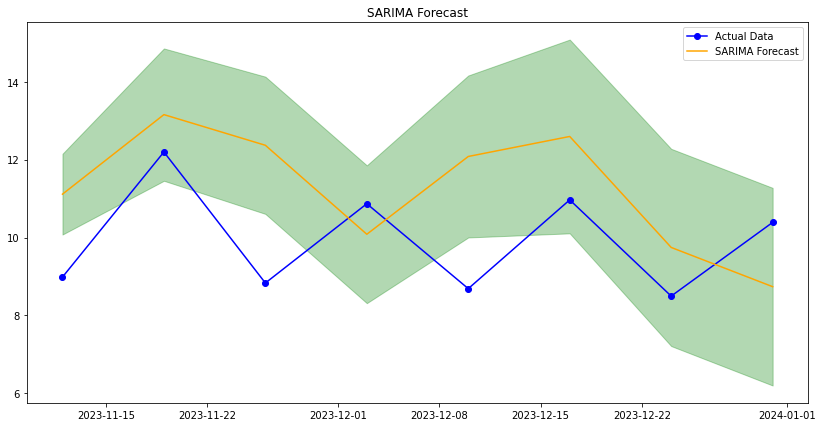

In [30]:
sarimax_forecast(w_forecast, 'Total Power Consumed (MW)', 4)

**Vessel 1 Weekly Power Forecast**
The same deductions as daily forecasts apply for the weekly analyses too:
Best SARIMA(0, 0, 0)x(0, 1, 0, 4) - AIC:140.56432053018307
RMSE:  2.291589529625523

**Vessel 2: Weekly Power Forecast**
The weekly forecast has a very wide confidence interval indicating hiher variance, and more uncertainity in forecast
- The true values and the forecasts are constantly offset
Best SARIMA(1, 0, 1)x(0, 1, 0, 4) - AIC:102.17357626984798
RMSE:  2.1498565166984434
R2 Score:  -1.8479834608544108

A negative R2 indicates a model misinterpretation

In [31]:
w_forecast_fuel = w_kpi[['Fuel Consumption per nautical mile', 'Total Power Consumed (MW)']]

SARIMA(0, 0, 0)x(0, 0, 0, 4) - AIC:833.1166594322457
SARIMA(0, 0, 0)x(0, 0, 1, 4) - AIC:786.0760625143391
SARIMA(0, 0, 0)x(0, 1, 0, 4) - AIC:529.2790073831253
SARIMA(0, 0, 0)x(0, 1, 1, 4) - AIC:526.1064754162043
SARIMA(0, 0, 0)x(1, 0, 0, 4) - AIC:604.5281369411609
SARIMA(0, 0, 0)x(1, 0, 1, 4) - AIC:601.7230412766824
SARIMA(0, 0, 0)x(1, 1, 0, 4) - AIC:529.1974335417752
SARIMA(0, 0, 0)x(1, 1, 1, 4) - AIC:526.2848806755403
SARIMA(0, 0, 1)x(0, 0, 0, 4) - AIC:777.4480248837718
SARIMA(0, 0, 1)x(0, 0, 1, 4) - AIC:729.1059298542131
SARIMA(0, 0, 1)x(0, 1, 0, 4) - AIC:490.7789865469558
SARIMA(0, 0, 1)x(0, 1, 1, 4) - AIC:489.6409722404022
SARIMA(0, 0, 1)x(1, 0, 0, 4) - AIC:552.6436574673229
SARIMA(0, 0, 1)x(1, 0, 1, 4) - AIC:10.0
SARIMA(0, 0, 1)x(1, 1, 0, 4) - AIC:491.5298494235536
SARIMA(0, 0, 1)x(1, 1, 1, 4) - AIC:489.89068496593086
SARIMA(0, 1, 0)x(0, 0, 0, 4) - AIC:484.99538375700973
SARIMA(0, 1, 0)x(0, 0, 1, 4) - AIC:486.81263162959175
SARIMA(0, 1, 0)x(0, 1, 0, 4) - AIC:468.5110232985432
SAR

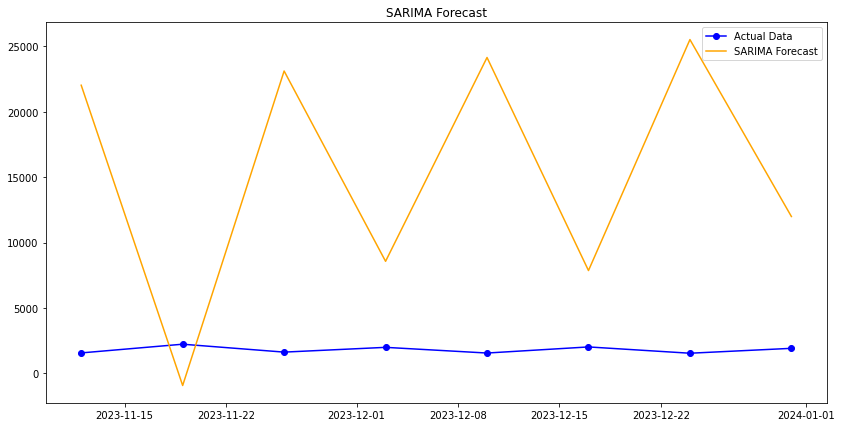

In [32]:
sarimax_forecast(w_forecast_fuel, 'Fuel Consumption per nautical mile', 4)  # Weekly forecast 4: weeks constituting a month

**Vessel 1 Fuel Consumption per nautical mile: Weekly**
- Acceptable performance by the model:
Best SARIMA(0, 1, 0)x(1, 1, 1, 4) - AIC:452.4464831963399
RMSE:  158.0555408961258

**Vessel 2 Fuel Consumption per nautical mile: Weekly**
- The model and the true value and miles apart and don't seem to align at all. This could be because of a lack of seasonality in weekly data for the vessel 2

In [ ]:
weekly_df.reset_index(inplace=True)
weekly_df.head()

In [ ]:
hourly_df.to_csv("hourly.csv")

In [ ]:
# Generate column Table
table = '| Column Name |\n|-------------|\n'
for column in weekly_df.columns:
    table += f'| {column} |\n'
print(table)